In [361]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import fiona

import time
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import rtree

In [348]:
import requests
import zipfile

In [2]:
from shapely.geometry import Point, Polygon, MultiLineString
from shapely.ops import unary_union

In [3]:
import rasterio as rio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import mapping
from rasterio.transform import Affine

In [4]:
shape_file_path = 'post_processing/remaymonthlyreportformassxwalkproject/Image_Index_2021/COQ2021INDEX_POLY.shp'
tile_gdb = 'post_processing/18TXM990635/Crosswalk_18TXM990635.gdb/'
results_gdb = 'post_processing/Combined_Results_2021.gdb/'
roads_gdb = 'post_processing/MassDOT_Roads_GDB/MassDOT_Roads_GDB/MassDOT_Roads.gdb/'

In [5]:
for i in fiona.listlayers(results_gdb):
    print(i)

Res_UTM_18
Res_UTM_19


In [71]:
for i in fiona.listlayers(roads_gdb):
    print(i)

EOTMAJROADS_ARC
EOTMAJROADS_RTE_MAJOR
EOTROADS_ARC


In [7]:
tile_path = os.path.join(tile_gdb)
results_path = os.path.join(results_gdb)
roads_path = os.path.join(roads_gdb)

### 2021 Shape file

In [8]:
shape_file = gpd.read_file(shape_file_path)

### Load results (Western Mass)

In [9]:
start = time.time()
western_mass = gpd.read_file(results_path, driver='FileGDB', layer=0)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:00:07.546795


### Load results (Eastern Mass)

In [10]:
start = time.time()
eastern_mass = gpd.read_file(results_path, driver='FileGDB', layer=1)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:00:27.518892


### Combined results

In [11]:
# Check if the CRS are different and if transformation is needed
if western_mass.crs != eastern_mass.crs:
    # Transform lyr2 to have the same CRS as lyr1
    eastern_mass_transformed = eastern_mass.to_crs(western_mass.crs)
else:
    eastern_mass_transformed = eastern_mass.crs
combined_results = gpd.GeoDataFrame(pd.concat([western_mass, eastern_mass_transformed], ignore_index=True), crs=western_mass.crs)

In [12]:
if western_mass.crs != shape_file.crs:
    shape_file_transformed = shape_file.to_crs(western_mass.crs)
else:
    shape_file_transformed = shape_file.crs

In [ ]:
len(eastern_mass_transformed)

125203

### Calculate statistics

In [12]:
quantiles = combined_results['Shape_Area'].quantile([0.25, 0.5, 0.75])
median_val = quantiles[0.5]
print("Quantiles: ")
quantiles

Quantiles: 


0.25     1.052525
0.50    20.152160
0.75    40.760909
Name: Shape_Area, dtype: float64

### Load road network

In [85]:
start = time.time()
major_roads_arc = gpd.read_file(roads_path, driver='FileGDB', layer=0)
major_roads_rte_major = gpd.read_file(roads_path, driver='FileGDB', layer=1)
roads_arc = gpd.read_file(roads_path, driver='FileGDB', layer=2)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:10:38.768230


In [337]:
len(roads_arc)

410029

In [93]:
# Combine them into a single GeoDataFrame
roads = gpd.GeoDataFrame(pd.concat([major_roads_arc, major_roads_rte_major, roads_arc], ignore_index=True))

In [229]:
def get_polygon_intersections(crosswalks, roads, contour_based=True, buffering_parameter=1, area_threshold=0.75):
    '''Return all detected polygons of a specified size which intersect with the road network.'''
    all_indices = list(crosswalks.index) # Create a list of all indices
    potential_intersections = []
    actual_intersections = []
    non_intersections = []
    potential_non_intersection_ids = []    
    
    # Create a dictionary to store unique IDs and their associated data
    unique_data = {}
    # Create an R-tree index (results)
    idx = rtree.index.Index()
    # Update indices to start at one
    indices_starting_at_one = [index + 1 for index in all_indices]
      
    
    # Calculate statistics
    quantiles = crosswalks['Shape_Area'].quantile([0.25, 0.5, 0.75])
    print("Quantiles:")
    print(quantiles)
    
    # Ensure the two dataset share a coordinate reference system (crs)
    if crosswalks.crs != roads.crs:
        roads_transformed = roads.to_crs(crosswalks.crs)
    else:
        roads_transformed = roads.crs
    
    # Populate the R-tree with the bounding boxes of the road segments
    for i, road_segment in enumerate(roads_transformed['geometry']):
        minx, miny, maxx, maxy = road_segment.bounds
        idx.insert(i, (minx, miny, maxx, maxy))
        
    # Query the R-tree for potential intersections
    for i in range(len(crosswalks)):
        polygon = crosswalks['geometry'][i]
        # Expand the original polygon by a specified distance in the same units as the crs
        buffered_polygon = polygon.buffer(buffering_parameter) # Adjust buffering parameter (proximity analysis / safety zone)
        bounding_box = buffered_polygon.bounds
        # Bounding box coordinates 
        minx, miny, maxx, maxy = bounding_box
        # Create a Polygon from the bounding box coordinates
        bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
        potential_intersections.append(list(idx.intersection(bounding_polygon.bounds))) 
    
    # Iterate through potential intersections and check for actual intersections
    for i, segment_list in enumerate(potential_intersections):
        object_id = i + 1
        polygon = crosswalks['geometry'][i]
        buffered_polygon = polygon.buffer(buffering_parameter)
        bounding_box = buffered_polygon.bounds
        # Bounding box coordinates
        minx, miny, maxx, maxy = bounding_box
        # Create a Polygon from the bounding box coordinates
        bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
        
        # Create a fixed bounding box
        polygon_centroid = polygon.centroid
        fixed_bounding_box = polygon_centroid.buffer(10)
        fminx, fminy, fmaxx, fmaxy = fixed_bounding_box.bounds
        viewing_window = Polygon([(fminx, fminy), (fmaxx, fminy), (fmaxx, fmaxy), (fminx, fmaxy), (fminx, fminy)])
        
        # Create lists to store all road segments that intersect with the polygon and the intersections
        road_segments = []    
        intersected_segments = []        
        # viewing_window_roadway = []
        
        # Define polygon of interest
        if contour_based:
            threshold_object = buffered_polygon
        else:
            threshold_object = bounding_polygon
        
        # Find non-intersections by adding the empty potential intersections
        if not segment_list:
            potential_non_intersection_ids.append(object_id)
        
        for segment_id in segment_list:
            road_segment = roads_transformed['geometry'][segment_id]
            # buffered_road_segment = road_segment.buffer(5)
            # Specify polygon area threshold (currently, 75th percentile)
            if threshold_object.intersects(road_segment) and polygon.area >= quantiles[area_threshold]: # TP criteria
                road_segments.append(road_segment)
                intersected_segments.append(threshold_object.intersection(road_segment))
                # Append the polygon and its intersected segments to the actual_intersections list
                actual_intersections.append((object_id, polygon, buffered_polygon, bounding_polygon, viewing_window, list(idx.intersection(viewing_window.bounds)), road_segments, intersected_segments))                                      
                                          
    # Iterate through the list and add unique data to the dictionary
    for item in actual_intersections:
        unique_id = item[0]
        if unique_id not in unique_data:
            unique_data[unique_id] = item

    # Convert the dictionary values back to a list to get unique items
    unique_data_list = list(unique_data.values())    
    intersection_ids = [item[0] for item in unique_data_list]
    remaining_non_intersection_ids = set(indices_starting_at_one) - (set(intersection_ids) | set(potential_non_intersection_ids))
    all_non_intersection_ids = sorted(list(potential_non_intersection_ids) + list(remaining_non_intersection_ids))    
    valid_indices = [index - 1 for index in all_non_intersection_ids if 1 <= index <= len(crosswalks)]
    
    for i in valid_indices:
        # viewing_window_roadway = []
        polygon = crosswalks['geometry'][i]
        buffered_polygon = polygon.buffer(buffering_parameter)
        bounding_box = buffered_polygon.bounds
        minx, miny, maxx, maxy = bounding_box
        bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
        polygon_centroid = polygon.centroid
        fixed_bounding_box = polygon_centroid.buffer(10)
        fminx, fminy, fmaxx, fmaxy = fixed_bounding_box.bounds
        viewing_window = Polygon([(fminx, fminy), (fmaxx, fminy), (fmaxx, fmaxy), (fminx, fmaxy), (fminx, fminy)])
        # viewing_window_roadway.append(list(idx.intersection(viewing_window.bounds)))
        non_intersections.append((i+1, polygon, buffered_polygon, bounding_polygon, viewing_window, list(idx.intersection(viewing_window.bounds))))
        
    # Check for matching IDs
    matching_ids = set([item[0] for item in unique_data_list]) & set([item[0] for item in non_intersections])
    if matching_ids:
        print("Matching IDs:", matching_ids)
    else:
        print("No matching IDs found.")
    
    combined_results = unique_data_list + non_intersections

    # Define a custom sorting key based on the first element (object_id) in each tuple
    sorting_key = lambda x: x[0]

    # Sort the combined list by object_id
    combined_results_sorted = sorted(combined_results, key=sorting_key)
    
    return(combined_results_sorted)

In [338]:
start = time.time()
contour_based_results = get_polygon_intersections(western_mass, roads_arc, contour_based=True, buffering_parameter=1, area_threshold=0.75)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

Quantiles:
0.25     0.277368
0.50     3.870911
0.75    29.994463
Name: Shape_Area, dtype: float64
No matching IDs found.
0:01:33.838947


In [347]:
contour_based_results[0]

(1,
 <MULTIPOLYGON (((718026.45 4701069.6, 718025.619 4701069.669, 718025.331 470...>,
 <POLYGON ((718027.389 4701069.255, 718027.35 4701069.163, 718027.301 4701069...>,
 <POLYGON ((718020.581 4701068.6, 718027.65 4701068.6, 718027.65 4701074.149,...>,
 <POLYGON ((718014.031 4701061.178, 718034.031 4701061.178, 718034.031 470108...>,
 [147642])

In [339]:
def convert_results_to_gdf(results):
    '''Convert polygon intersection results to a GeoDataFrame.'''
    if isinstance(results, gpd.GeoDataFrame):
        geo_df = results
    else:
        # Initialize empty lists to store GeoDataFrame columns
        ids = []
        polygons = []
        buffered_polygons = []
        bounding_polygons = []
        viewing_windows = []
        viewing_window_roadways = []
        multilinestrings = []
        intersections = []

        # Extract data from each entry in results
        for entry in results:
            object_id, polygon, buffered_polygon, bounding_polygon, viewing_window, viewing_window_roadway, *rest = entry
            # Assign default values to multilines and lines
            multilines = [] if len(rest) < 2 else rest[0]
            lines = [] if len(rest) < 2 else rest[1]
            
            # Append data to the lists
            ids.append(object_id)
            polygons.append(polygon)
            buffered_polygons.append(buffered_polygon)
            bounding_polygons.append(bounding_polygon)
            viewing_windows.append(viewing_window)
            viewing_window_roadways.append(viewing_window_roadway)
            multilinestrings.append(multilines)
            intersections.append(lines)

        # Create a dictionary with field names as keys and lists as values
        data = {
            'object_id': ids,
            'polygon': polygons,
            'buffered_polygon': buffered_polygons,
            'bounding_polygon': bounding_polygons,
            'viewing_window': viewing_windows,
            'viewing_window_roadway': viewing_window_roadways,
            'road_segments': multilinestrings,
            'intersections': intersections,
        }

        # Create the GeoDataFrame
        geo_df = gpd.GeoDataFrame(data, geometry='polygon')

    return(geo_df)

In [340]:
res_contour_gdf = convert_results_to_gdf(contour_based_results)
# res_box_gdf = convert_results_to_gdf(bounding_box_results)

In [234]:
res_contour_gdf.head()

object_id                                            polygon  \
0          1  MULTIPOLYGON (((718026.450 4701069.600, 718025...   
1          2  MULTIPOLYGON (((717983.250 4703825.550, 717982...   
2          3  MULTIPOLYGON (((717092.850 4705067.700, 717092...   
3          4  MULTIPOLYGON (((717086.250 4705063.350, 717085...   
4          5  MULTIPOLYGON (((717074.700 4705056.150, 717073...   

                                    buffered_polygon  \
0  POLYGON ((718027.3887347876 4701069.255359609,...   
1  POLYGON ((717984.25 4703825.550000001, 717984....   
2  POLYGON ((717091.5156151623 4705068.380365478,...   
3  POLYGON ((717086.9069187535 4705062.597692916,...   
4  POLYGON ((717074.4603628933 4705057.497884298,...   

                                    bounding_polygon  \
0  POLYGON ((718020.5807176639 4701068.6001407225...   
1  POLYGON ((717981.7999999998 4703824.550000001,...   
2  POLYGON ((717091.3090021071 4705066.700484638,...   
3  POLYGON ((717083.9675955271 4705062.350534283,...   
4  POLYGON ((717072.8894274653 4705055.150025865,...   

                                      viewing_window  \
0  POLYGON ((718014.0306429939 4701061.178288448,...   
1  POLYGON ((717973.0249999998 4703815.700000003,...   
2  POLYGON ((717087.1906881498 4705061.630852473,...   
3  POLYGON ((717077.9652958091 4705055.515461192,...   
4  POLYGON ((717065.5407489152 4705046.949866314,...   

                        viewing_window_roadway road_segments intersections  
0          [15282, 15288, 15296, 4016, 162960]            []            []  
1          [15282, 15288, 15296, 4016, 204357]            []            []  
2  [15282, 15288, 15296, 4016, 179050, 386549]            []            []  
3  [15282, 15288, 15296, 4016, 179050, 386549]            []            []  
4  [15282, 15288, 15296, 4016, 179050, 386549]            []            []

In [341]:
def map_polygon_to_tile(gdf, shape_file):
    '''Determine the tile each detected polygon belongs to using the index approach.'''
    # Create a dictionary to store the mapping of polygons to tiles
    gdf_results = gdf.copy()
    polygon_to_tile = {}

    # Create spatial indices for both geo_df and shape_file
    gdf_sindex = gdf_results.sindex
    shape_file_sindex = shape_file.sindex

    # Iterate through the polygons in geo_df
    for geo_index, geo_row in gdf_results.iterrows():
        geo_bounds = geo_row['polygon'].bounds

        # Iterate through the tiles in the shape_file
        for tile_index in shape_file_sindex.intersection(geo_bounds):
            tile_geometry = shape_file.at[tile_index, 'geometry']

            # Check if the bounding box of the polygon intersects with the tile
            if geo_row['polygon'].intersects(tile_geometry):
                polygon_to_tile[geo_index] = shape_file.at[tile_index, 'TILENAME']
                break  # Stop checking further tiles once a match is found

    # Create a new column in geo_df to store the corresponding tile name
    gdf_results['TILENAME'] = gdf_results.index.map(polygon_to_tile)
    return(gdf_results)

In [236]:
if western_mass.crs != shape_file.crs:
    shape_file_transformed = shape_file.to_crs(western_mass.crs)
else:
    shape_file_transformed = shape_file.crs

In [342]:
start = time.time()
contour_polygon_mappings = map_polygon_to_tile(res_contour_gdf, shape_file_transformed)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:00:05.999500


In [308]:
target_length = 3  
# Find the first entry with the desired length
for index, row in contour_polygon_mappings.iterrows():
    if len(row['road_segments']) == target_length:
        first_entry_with_length_3 = row
        break

In [309]:
first_entry_with_length_3

object_id                                                               111
polygon                   MULTIPOLYGON (((721227.9000000013 4715521.9499...
buffered_polygon          POLYGON ((721226.9006327331 4715521.985567727,...
bounding_polygon          POLYGON ((721226.4412841802 4715509.681417931,...
viewing_window            POLYGON ((721223.8479469009 4715507.215343799,...
viewing_window_roadway    [15288, 15296, 7331, 11224, 421707, 349382, 34...
road_segments             [MULTILINESTRING ((721239.5339061376 4715518.1...
intersections             [LINESTRING (721239.5339061376 4715518.1066288...
TILENAME                                                        18TYN200145
Name: 110, dtype: object

In [318]:
example = contour_polygon_mappings.iloc[110][6]
len(example)

3

<AxesSubplot:>

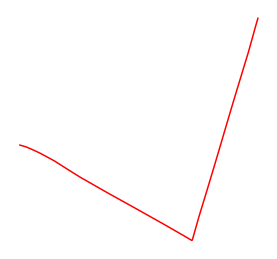

In [346]:
example = contour_polygon_mappings.iloc[132][6]
# Create a DataFrame with the LINESTRINGs
data = {'geometry': example}
df = gpd.GeoDataFrame(data, geometry='geometry')
# Visualize the itnersection
fig, ax = plt.subplots()
plt.tight_layout()
ax.axis('off')
df.plot(ax=ax, color='red')

In [284]:
def visualize_intersection(crosswalk_intersections, idx, contour_based=True, zoom_in=True, save_fig=False):
    '''Sketch out a polygon intersection without an aerial overlay.'''
    tp = True
    zoom_feature = ''
    if tp:
        cat = 'tp'
        if not(zoom_in):
            zoom_feature = '_zoom-out'
    else:
        cat = 'fp' 
        
    if isinstance(crosswalk_intersections, list):
        observation = crosswalk_intersections[idx]
        if(len(observation)==4):
            tp = False
    else:
        observation = crosswalk_intersections.iloc[idx]
        if not observation['road_segments']:
            tp = False
    # Visualize the intersection
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.axis('off')
    # Convert objects to geodataframes (gdfs)
    object_id = observation[0]
    polygon_gdf = gpd.GeoDataFrame(geometry=[observation[1]])
    buffered_polygon_gdf = gpd.GeoDataFrame(geometry=[observation[2]])
    bounding_polygon_gdf = gpd.GeoDataFrame(geometry=[observation[3]])
    viewing_window_gdf = gpd.GeoDataFrame(geometry=[observation[4]])
    # viewing_window_roadway_gdf = gpd.GeoDataFrame({'geometry':roads['geometry'][observation[5]]}, geometry='geometry')
    if(tp):
        road_segment_gdf = gpd.GeoDataFrame({'geometry': observation[6]}, geometry='geometry')
        intersection_gdf = gpd.GeoDataFrame({'geometry': observation[7]}, geometry='geometry')
        if(zoom_in):
            intersection_gdf.plot(ax=ax, color='green')
        else:
            road_segment_gdf.plot(ax=ax, color='green')
    polygon_gdf.plot(ax=ax, color='red')
    buffered_polygon_gdf.boundary.plot(ax=ax, linewidth=1, color='blue')
    bounding_polygon_gdf.boundary.plot(ax=ax, linewidth=2, color='pink')
    viewing_window_gdf.boundary.plot(ax=ax, linewidth=2, color='orange')
    # viewing_window_roadway_gdf.plot(ax=ax, color='purple', zorder=1000)
    plt.title(f'Object ID: {object_id} ({cat.upper()}) \n Polygon area: {polygon_gdf.area[0]:.2f}m² \n Viewing window area (orange): {viewing_window_gdf.area[0]:.2f}m² \n Bounding box area (pink): {bounding_polygon_gdf.area[0]:.2f}m² \n Buffer size: 1m')
    if save_fig:  
        # Specify the directory path
        save_dir = "post_processing/simple_polygon_intersections/"
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)             
        
        if contour_based:
            contour_feature = '_contour'
        else:
            contour_feature = '_box'
        
        # Specify the figure title and file path
        fig_title = os.path.join(save_dir, f"intersection-{object_id}_{cat}{zoom_feature}{contour_feature}.jpg")
        
        # Save the figure
        plt.savefig(fig_title, dpi=300, bbox_inches='tight')
    plt.show() 

In [391]:
res_contour_gdf[res_contour_gdf['object_id']==11]['polygon'].area

10    35.766589
dtype: float64

In [381]:
if western_mass.crs != roads_arc.crs:
    roads_arc_transformed = roads_arc.to_crs(western_mass.crs)
else:
    roads_arc_transformed = roads_arc.crs

In [409]:
res_contour_gdf[res_contour_gdf['object_id']==10]

object_id                                            polygon  \
9         10  MULTIPOLYGON (((717496.650 4708784.550, 717493...   

                                    buffered_polygon  \
9  POLYGON ((717497.3093788966 4708783.799266193,...   

                                    bounding_polygon  \
9  POLYGON ((717492.3554777139 4708783.550285313,...   

                                      viewing_window viewing_window_roadway  \
9  POLYGON ((717486.2580720398 4708775.421089949,...                     []   

  road_segments intersections  
9            []            []


Polygon area:  168    26.208639
dtype: float64
18TYN200175 already exists, skipping download.
aerial_imagery/18TYN200175/18TYN200175.jp2
Viewing window intersections 
 45760    MULTILINESTRING ((720674.303 4718477.546, 7206...
Name: geometry, dtype: geometry


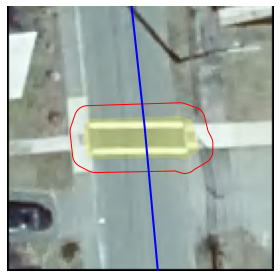

0:00:06.177502


In [411]:
start = time.time()
tp_object_ids = [144, 145] #, 35146, 35151, 35153, 35154, 35212]
for tpoid in [169]:#[x for x in range(179, 182)]:
    index = res_contour_gdf[res_contour_gdf['object_id']==tpoid].index[0]
    print("\nPolygon area: ", res_contour_gdf[res_contour_gdf['object_id']==tpoid]['polygon'].area)
    superimpose_polygon_on_tile(contour_polygon_mappings, index, True, False, True)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

In [150]:
contour_polygon_mappings.head()

object_id                                            polygon  \
0          1  MULTIPOLYGON (((718026.450 4701069.600, 718025...   
1          2  MULTIPOLYGON (((717983.250 4703825.550, 717982...   
2          3  MULTIPOLYGON (((717092.850 4705067.700, 717092...   
3          4  MULTIPOLYGON (((717086.250 4705063.350, 717085...   
4          5  MULTIPOLYGON (((717074.700 4705056.150, 717073...   

                                    buffered_polygon  \
0  POLYGON ((718027.3887347876 4701069.255359609,...   
1  POLYGON ((717984.25 4703825.550000001, 717984....   
2  POLYGON ((717091.5156151623 4705068.380365478,...   
3  POLYGON ((717086.9069187535 4705062.597692916,...   
4  POLYGON ((717074.4603628933 4705057.497884298,...   

                                    bounding_polygon  \
0  POLYGON ((718020.5807176639 4701068.6001407225...   
1  POLYGON ((717981.7999999998 4703824.550000001,...   
2  POLYGON ((717091.3090021071 4705066.700484638,...   
3  POLYGON ((717083.9675955271 4705062.350534283,...   
4  POLYGON ((717072.8894274653 4705055.150025865,...   

                                      viewing_window  \
0  POLYGON ((718014.0306429939 4701061.178288448,...   
1  POLYGON ((717973.0249999998 4703815.700000003,...   
2  POLYGON ((717087.1906881498 4705061.630852473,...   
3  POLYGON ((717077.9652958091 4705055.515461192,...   
4  POLYGON ((717065.5407489152 4705046.949866314,...   

                        viewing_window_roadway road_segments intersections  \
0          [15282, 15288, 15296, 4016, 162960]            []            []   
1          [15282, 15288, 15296, 4016, 204357]            []            []   
2  [15282, 15288, 15296, 4016, 179050, 386549]            []            []   
3  [15282, 15288, 15296, 4016, 179050, 386549]            []            []   
4  [15282, 15288, 15296, 4016, 179050, 386549]            []            []   

      TILENAME  
0  18TYN170010  
1  18TYN170025  
2  18TYN170040  
3  18TYN170040  
4  18TYN170040

In [155]:
contour_polygon_mappings.iloc[1]['viewing_window_roadway'][0]

15282

In [189]:
roads['geometry'][contour_polygon_mappings['viewing_window_roadway'][1]].tolist()

[<MULTILINESTRING ((156962.344 886911.25, 156972.906 886904.437, 157000 88690...>,
 <MULTILINESTRING ((231846.078 900657.782, 231839.984 900662.798, 231825.929 ...>,
 <MULTILINESTRING ((92726.771 861900.062, 92726.211 861917.62, 92723.991 8619...>,
 <MULTILINESTRING ((125215.062 893599.625, 125214.297 893791.188, 125214.097 ...>,
 <MULTILINESTRING ((129152.43 912060.812, 129153.047 912060.625, 129167.953 9...>]

In [190]:
roads['geometry'][contour_polygon_mappings.iloc[1]['viewing_window_roadway']].tolist()

[<MULTILINESTRING ((156962.344 886911.25, 156972.906 886904.437, 157000 88690...>,
 <MULTILINESTRING ((231846.078 900657.782, 231839.984 900662.798, 231825.929 ...>,
 <MULTILINESTRING ((92726.771 861900.062, 92726.211 861917.62, 92723.991 8619...>,
 <MULTILINESTRING ((125215.062 893599.625, 125214.297 893791.188, 125214.097 ...>,
 <MULTILINESTRING ((129152.43 912060.812, 129153.047 912060.625, 129167.953 9...>]

In [351]:
# Function to download and unzip a file if it hasn't been downloaded already
def download_and_unzip(tile_name):
    extraction_path = os.path.join('aerial_imagery', tile_name)

    # Check if the directory for the tile already exists
    if os.path.exists(extraction_path):
        print(f"{tile_name} already exists, skipping download.")
        return

    # Define the URL and local file path
    url = f"https://s3.us-east-1.amazonaws.com/download.massgis.digital.mass.gov/images/coq2021_15cm_jp2/{tile_name}.zip"
    local_file_path = os.path.join('aerial_imagery', f"{tile_name}.zip")
    
    # Ensure the 'aerial_imagery' directory exists
    os.makedirs('aerial_imagery', exist_ok=True)

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {tile_name}.zip")

        # Unzip the file
        with zipfile.ZipFile(local_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
        print(f"Unzipped {tile_name}.zip")

        # Remove the zip file after extraction
        os.remove(local_file_path)
    else:
        print(f"Failed to download {tile_name}.zip")

In [373]:
# Function to check if a file exists at the specified path
def check_and_download(tile_name):
    # Define the path to check
    local_path = f'D:/mass_xwalk/COQ2021INDEX/unzipped/{tile_name}.jp2'
    local_path = local_path.replace('\\', '/')
    aerial_img_path = ''
    
    # Check if the file exists
    if os.path.exists(local_path):
        print(f"{local_path} already exists, skipping download.")
        aerial_img_path = local_path
    else:
        # Call the download_and_unzip function
        download_and_unzip(tile_name)
        aerial_img_path = os.path.join('aerial_imagery', f"{tile_name}/", f"{tile_name}.jp2")
        aerial_img_path = aerial_img_path.replace('\\', '/')
            
    return(aerial_img_path)

In [382]:
def superimpose_polygon_on_tile(mappings, idx, view_window=True, grayscale=False, savefig=False):
    tp = True
    entry = mappings.iloc[idx]
    tilename = entry['TILENAME']
    polygon = entry['polygon']
    buffered_polygon = entry['buffered_polygon']
    bounding_polygon = entry['bounding_polygon'] 
    viewing_window = entry['viewing_window']
    viewing_window_roadway = roads_arc_transformed['geometry'][entry['viewing_window_roadway']]#.tolist()
    
    if not entry['road_segments']:
        tp = False
    else:
        road_segments = entry['road_segments']    
    
    # Check if the aerial image exists locally, otherwise download it first
    aerial_img_path = check_and_download(tilename)
    print(aerial_img_path)
    
    if view_window:
        view_box_gdf = gpd.GeoDataFrame({'geometry': [viewing_window]})
    else:
        view_box_gdf = gpd.GeoDataFrame({'geometry': [bounding_polygon]})
    
    # Open the aerial image with rasterio
    with rio.open(aerial_img_path) as src:
        # Read the three bands representing RGB channels
        red_channel = src.read(1)
        green_channel = src.read(2)
        blue_channel = src.read(3)
        # Clip each color channel to the polygon extent
        clipped_red_channel, transform = rasterio.mask.mask(src, view_box_gdf.geometry.apply(mapping), crop=True, indexes=1)
        clipped_green_channel, _ = rasterio.mask.mask(src, view_box_gdf.geometry.apply(mapping), crop=True, indexes=2)
        clipped_blue_channel, _ = rasterio.mask.mask(src, view_box_gdf.geometry.apply(mapping), crop=True, indexes=3)
        # Stack the clipped color channels to create a composite RGB image
        clipped_image = np.stack((clipped_red_channel, clipped_green_channel, clipped_blue_channel), axis=0)        

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(4, 4))#, dpi=300)

    # Create a GeoSeries containing the MULTIPOLYGON
    gdf_polygon_series = gpd.GeoSeries(polygon)
    gdf_buffer_series = gpd.GeoSeries(buffered_polygon)
    gdf_viewing_window_roadway_series = gpd.GeoSeries(viewing_window_roadway)
    print("Viewing window intersections \n", gdf_viewing_window_roadway_series)
    
    # Plot the polygon on the same axis
    gdf_polygon_series.plot(ax=ax, facecolor='yellow', edgecolor='none', alpha=0.2, antialiased=True)
    gdf_buffer_series.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, antialiased=True)
    gdf_viewing_window_roadway_series.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, antialiased=True)
    
    if tp:
        gdf_road_series = gpd.GeoSeries(road_segments)
        print("Tp \n", gdf_road_series)
        gdf_road_series.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2, antialiased=True)

    # Plot the clipped JP2 image on the same axis
    if view_window:
        extent = viewing_window.bounds#(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    else:
        extent = bounding_polygon.bounds

    # Configure the plot
    if(grayscale):
        # plot_title = 'Polygon overlay on clipped grayscale aerial image'
        show(clipped_image[0], cmap='gray', extent=(extent[0], extent[2], extent[1], extent[3]), ax=ax, alpha=1.0, transform=transform)  # Set alpha to 1.0 to avoid transparency
    else:
        # plot_title = 'Polygon overlay on clipped color aerial image'
        show(clipped_image, transform=transform, extent=(extent[0], extent[2], extent[1], extent[3]), ax=ax, alpha=1.0)  # Set alpha to 1.0 to avoid transparency
    # ax.set_title(plot_title)
    ax.axis('off')
    plt.tight_layout()

    if(savefig):
        # Specify the directory path
        save_dir = "post_processing/overlays/"
        if tp:
            cat = '_tp'
        else:
            cat = '_fp'
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        # Specify the figure title and file path
        fig_title = os.path.join(save_dir, f"clipped_overlay-{entry['object_id']}{cat}.png")        
        # Save the figure
        plt.savefig(fig_title, dpi=600, format='png', bbox_inches='tight')

    # Show the plot
    plt.show()

Object ID:  111


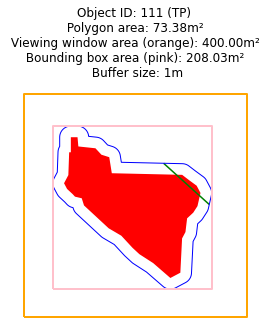

18TYN200145 already exists, skipping download.
aerial_imagery/18TYN200145/18TYN200145.jp2
Viewing window intersections 
 333658    MULTILINESTRING ((721519.192 4715171.186, 7215...
334064    MULTILINESTRING ((721239.534 4715518.107, 7212...
406389    MULTILINESTRING ((721180.524 4715571.385, 7212...
Name: geometry, dtype: geometry
Tp 
 0    MULTILINESTRING ((721519.192 4715171.186, 7215...
1    MULTILINESTRING ((721239.534 4715518.107, 7212...
dtype: geometry


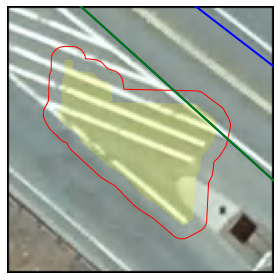

Object ID:  133


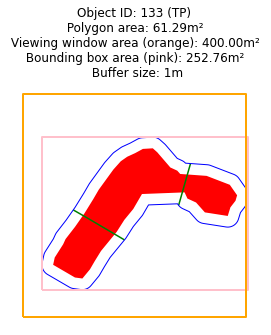

18TYN200175 already exists, skipping download.
aerial_imagery/18TYN200175/18TYN200175.jp2
Viewing window intersections 
 355289    MULTILINESTRING ((721170.438 4718852.945, 7211...
355288    MULTILINESTRING ((721046.392 4718921.618, 7210...
157405    MULTILINESTRING ((721170.427 4718852.952, 7211...
Name: geometry, dtype: geometry
Tp 
 0    MULTILINESTRING ((721046.392 4718921.618, 7210...
1    MULTILINESTRING ((721170.427 4718852.952, 7211...
dtype: geometry


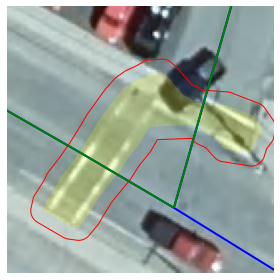

Object ID:  153


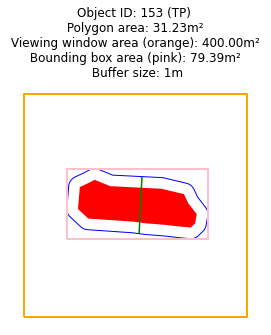

18TYN200175 already exists, skipping download.
aerial_imagery/18TYN200175/18TYN200175.jp2
Viewing window intersections 
 324084    MULTILINESTRING ((720318.352 4718635.707, 7203...
324054    MULTILINESTRING ((720340.030 4718635.726, 7203...
100790    MULTILINESTRING ((720340.031 4718635.726, 7203...
Name: geometry, dtype: geometry
Tp 
 0    MULTILINESTRING ((720340.031 4718635.726, 7203...
dtype: geometry


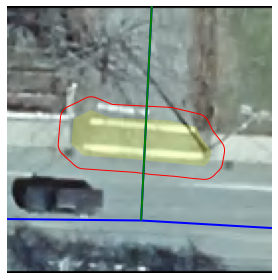

Object ID:  156


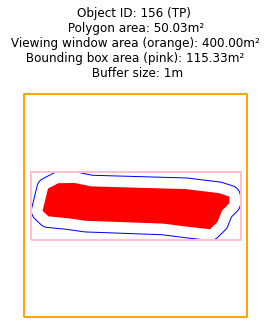

18TYN200175 already exists, skipping download.
aerial_imagery/18TYN200175/18TYN200175.jp2
Viewing window intersections 
 323855    MULTILINESTRING ((720043.831 4718653.023, 7200...
138623    MULTILINESTRING ((720280.335 4718605.669, 7202...
Name: geometry, dtype: geometry


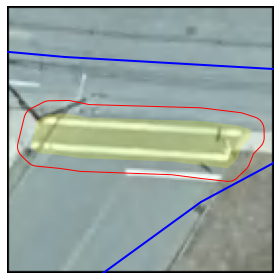

0:00:26.002887


In [385]:
start = time.time()
alley_xwalks = [111, 133, 153, 156] #111, 153, 154]#, 156, 157, 159]
for i in alley_xwalks:
    print("Object ID: ", i)
    idx = contour_polygon_mappings[contour_polygon_mappings['object_id']==i].index[0]
    visualize_intersection(res_contour_gdf, idx)    
    superimpose_polygon_on_tile(contour_polygon_mappings, idx, True, False, True)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200145.jp2


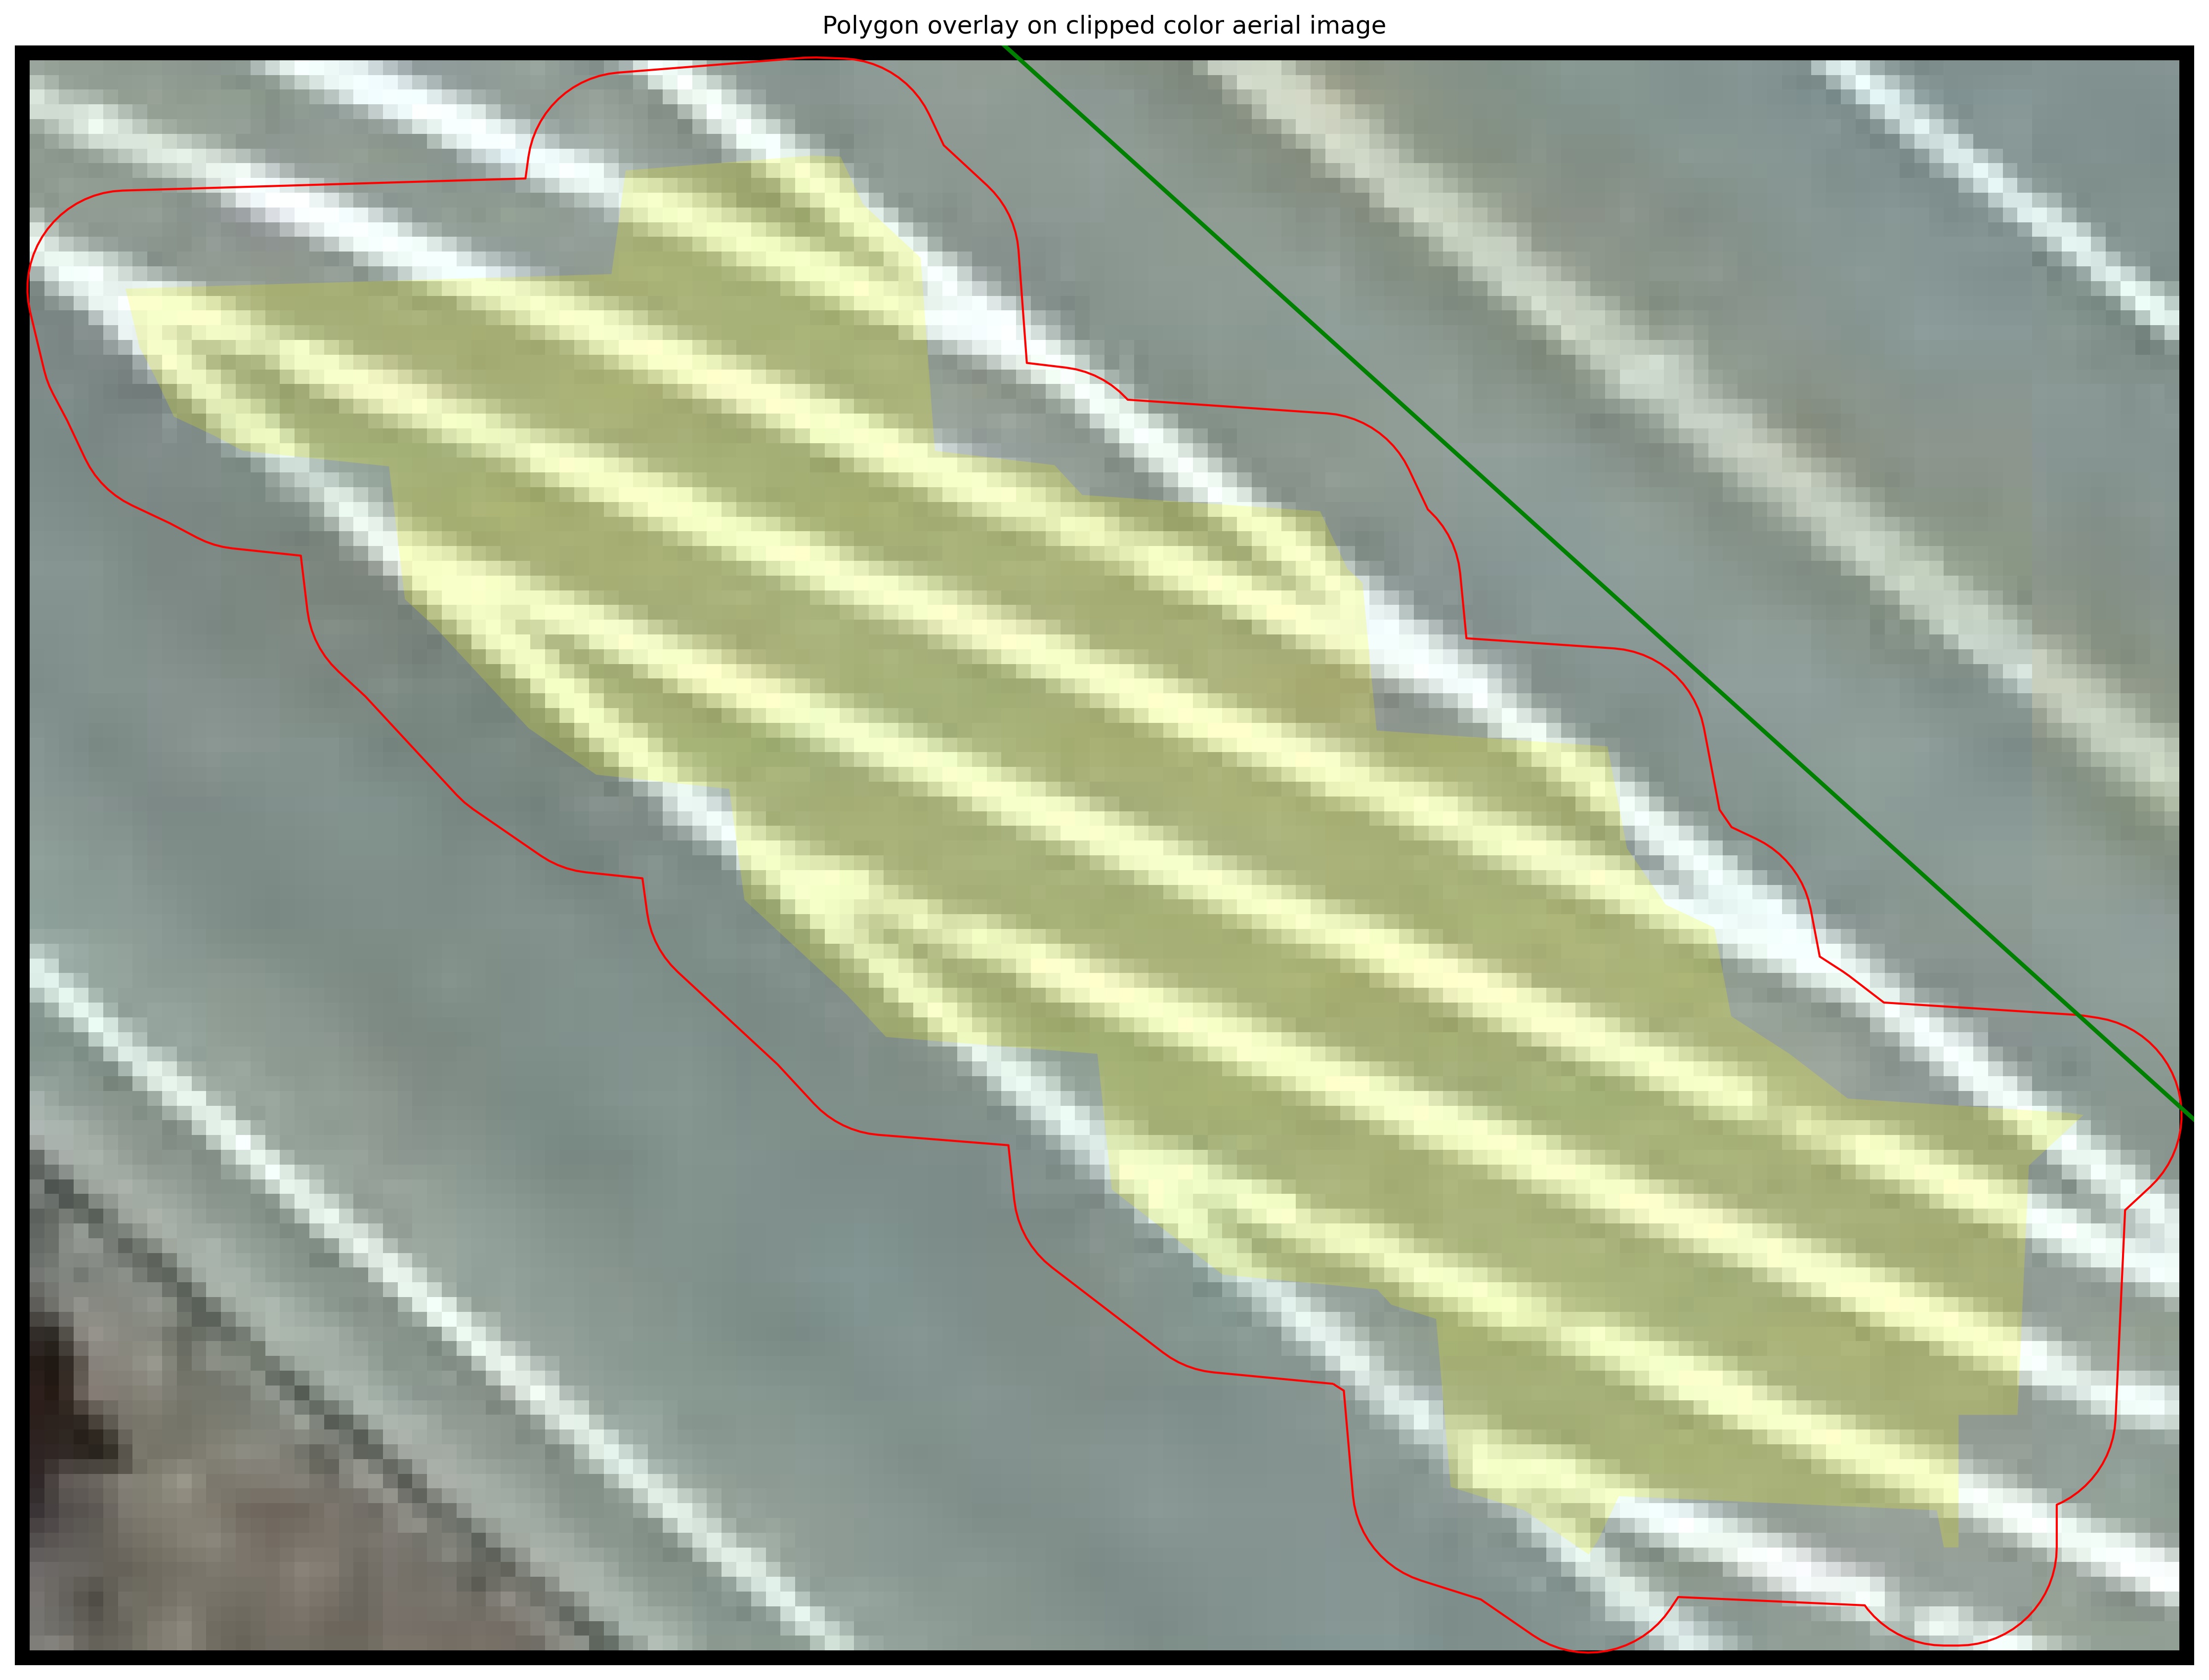

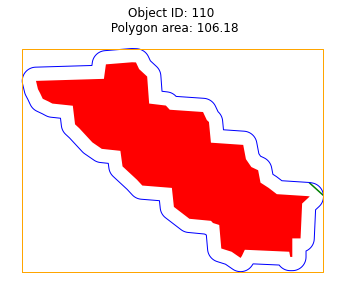

D:/mass_xwalk/COQ2021INDEX/unzipped/18TXM990905.jp2


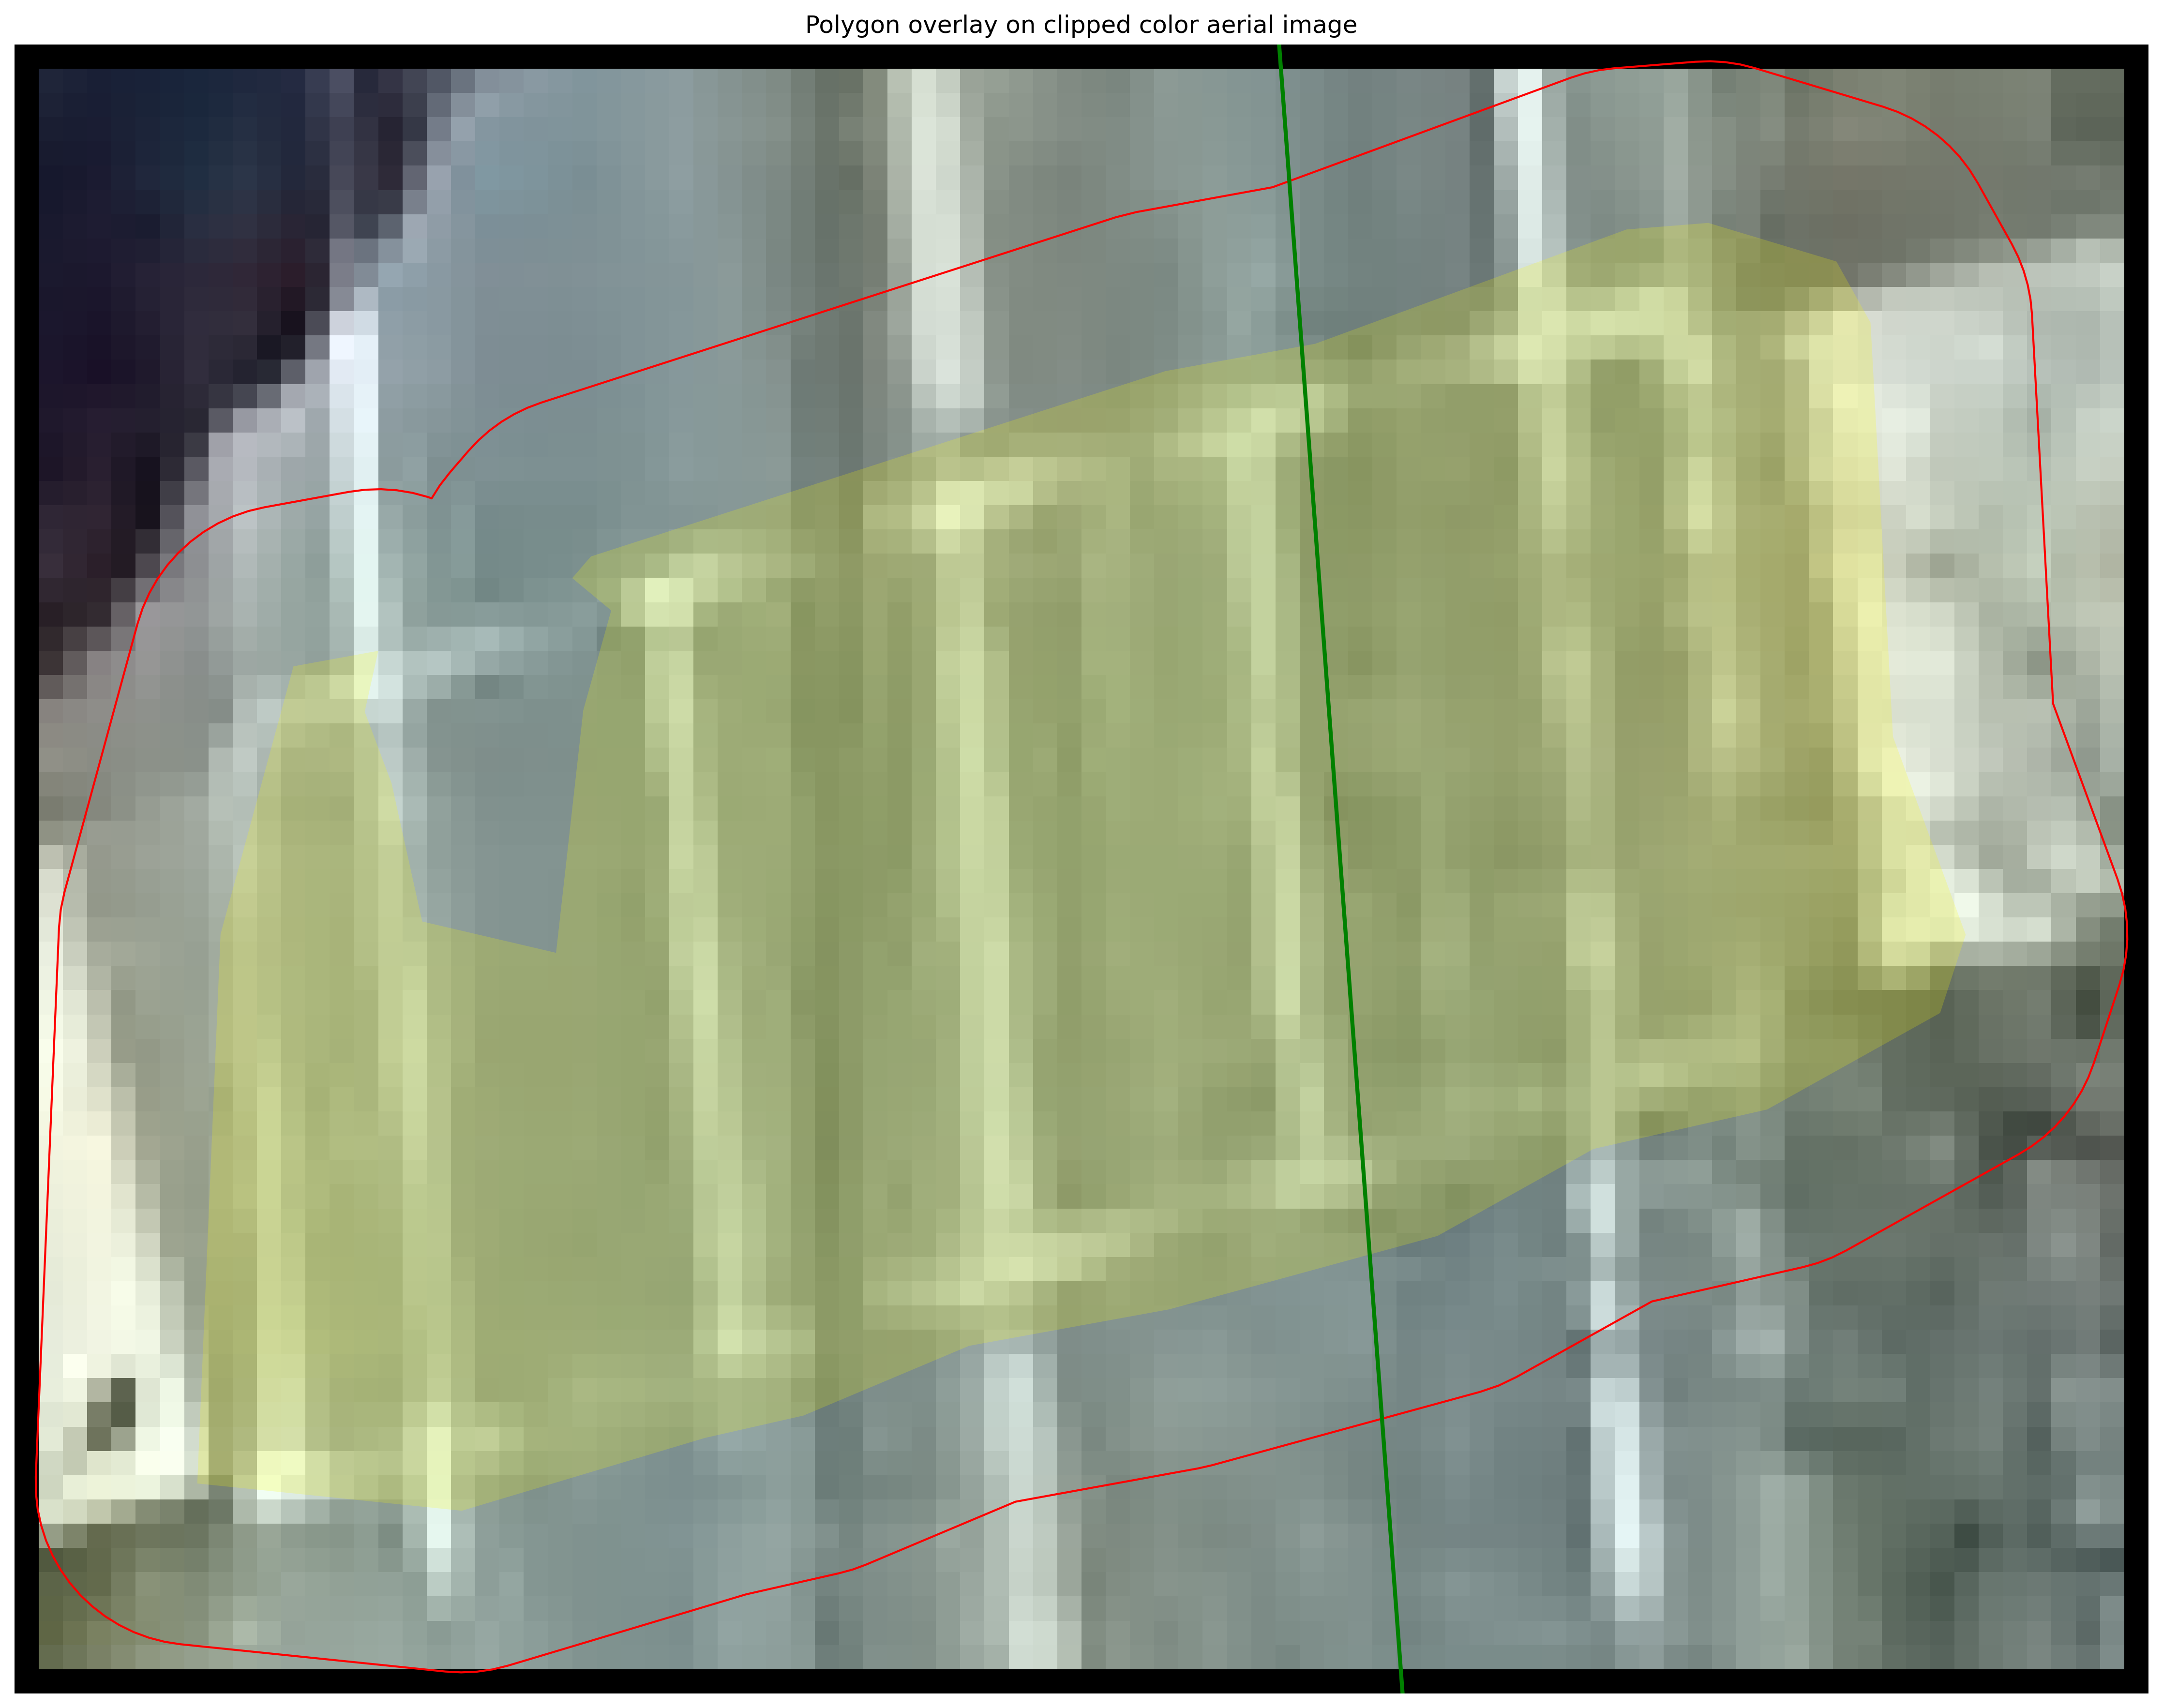

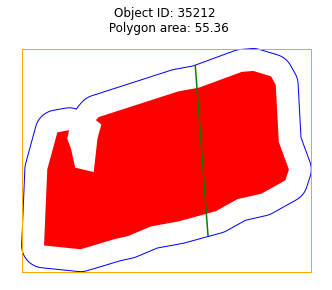

In [38]:
for i in [110, 35212]:
    index = contour_polygon_mappings[contour_polygon_mappings['object_id']==i].index[0]
    superimpose_polygon_on_tile(contour_polygon_mappings, index, False, True)
    visualize_intersection(res_contour_gdf, index)

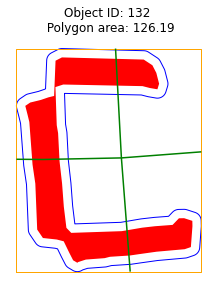

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


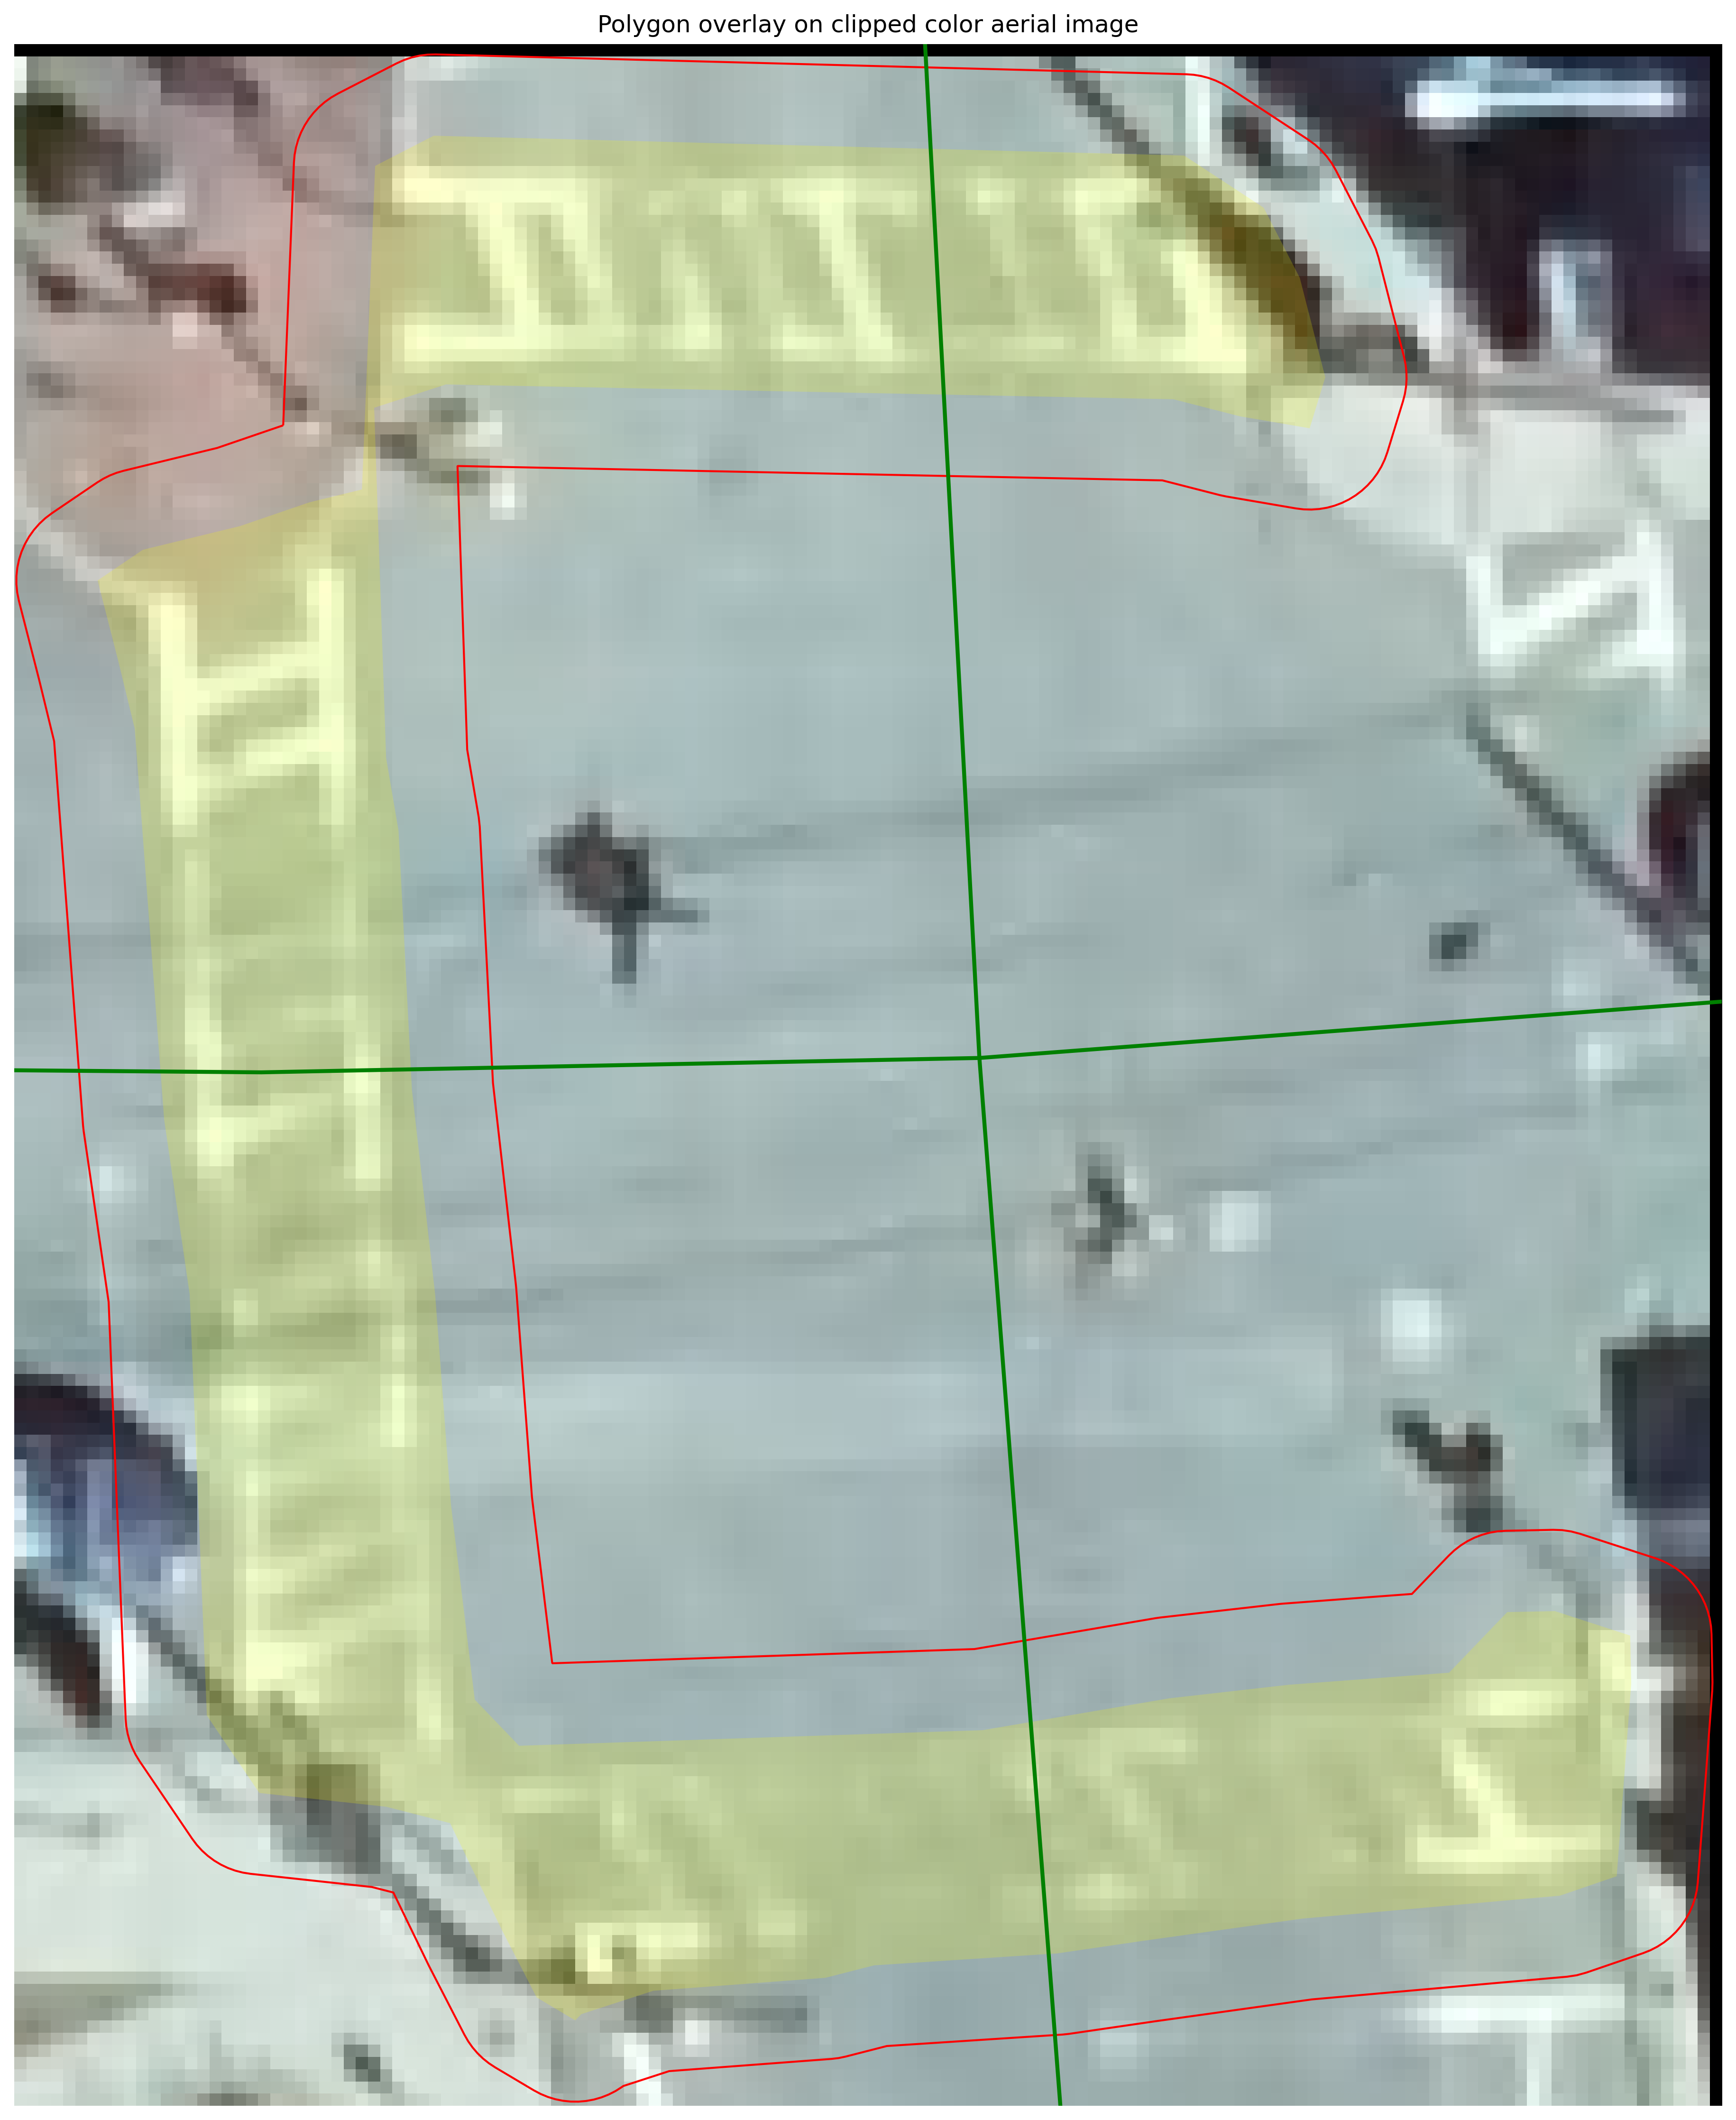

In [85]:
i = 11
visualize_intersection(res_box_gdf, i)
superimpose_polygon_on_tile(box_polygon_mappings, i)

In [377]:
contour_polygon_mappings[contour_polygon_mappings['object_id']==159] #alley

object_id                                            polygon  \
158        159  MULTIPOLYGON (((720386.700 4718624.100, 720385...   

                                      buffered_polygon  \
158  POLYGON ((720387.0971534047 4718623.183029841,...   

                                      bounding_polygon road_segments  \
158  POLYGON ((720384.1265545464 4718623.100980879,...            []   

    intersections     TILENAME  
158            []  18TYN200175

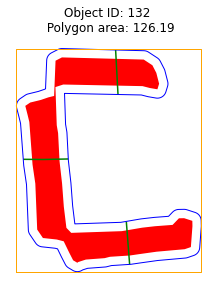

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


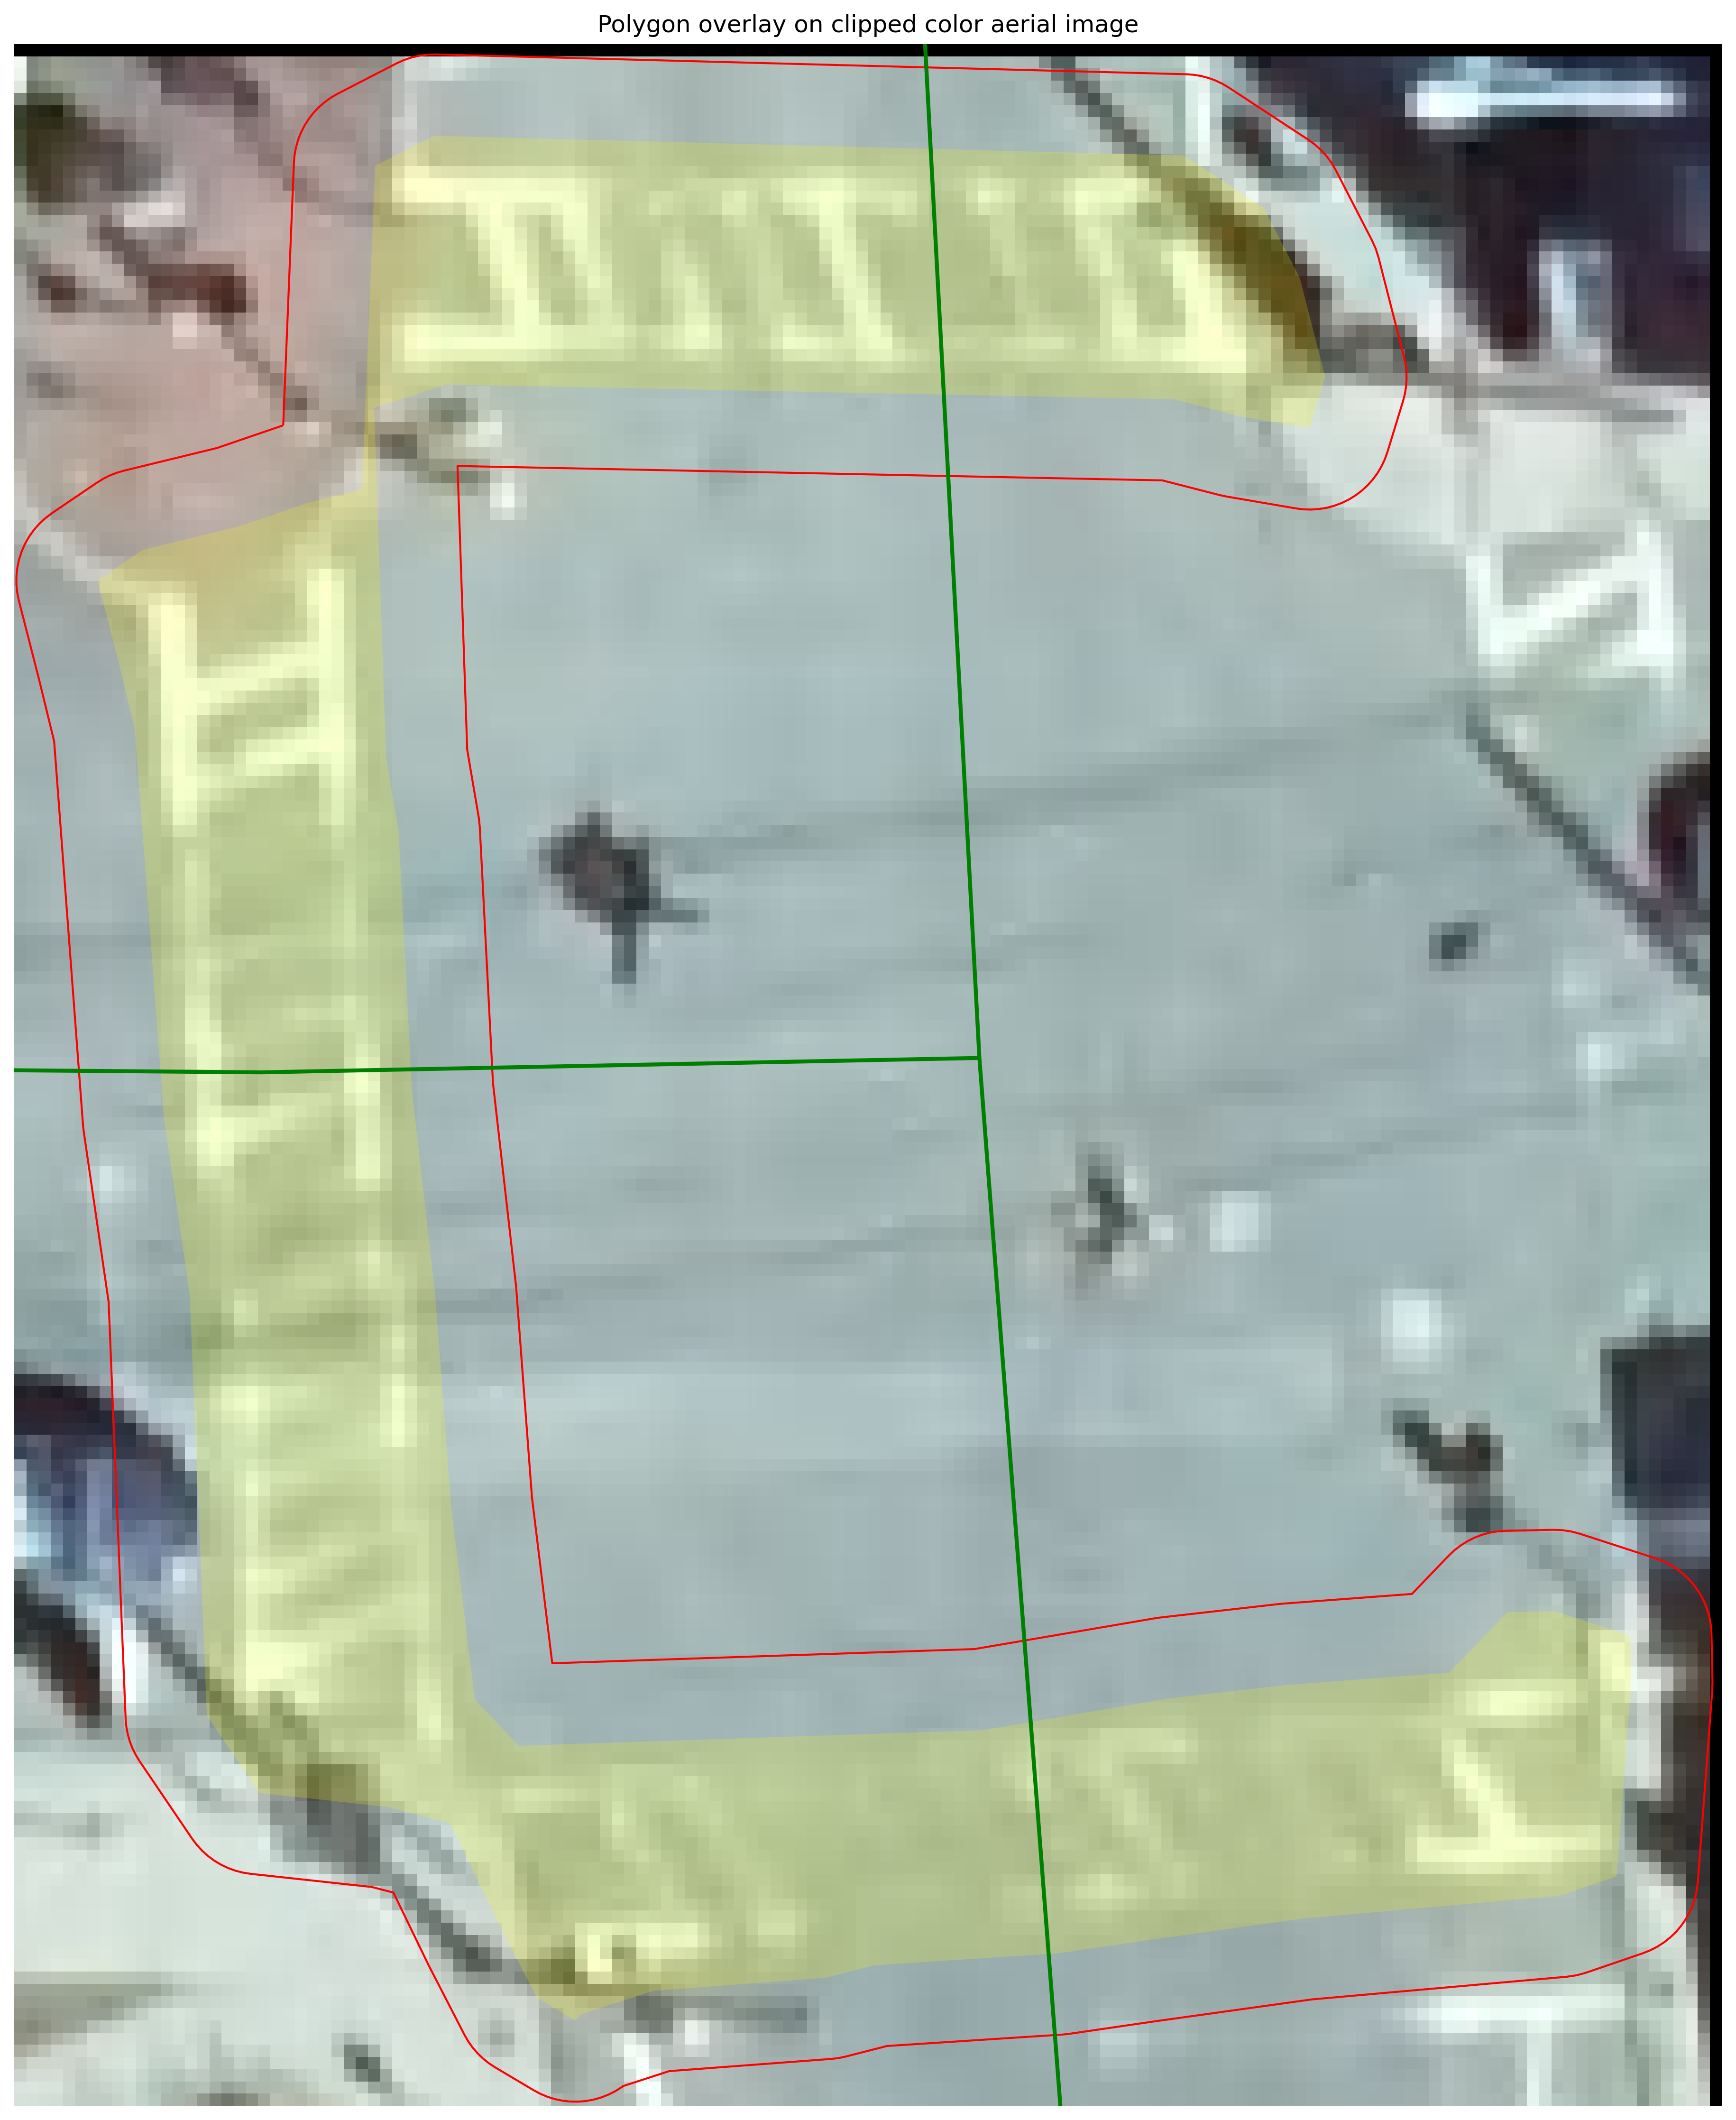

In [370]:
i = 131
visualize_intersection(res_contour_gdf, i)
superimpose_polygon_on_tile(contour_polygon_mappings, i)

In [70]:
start = time.time()
polygon_mappings = map_polygon_to_tile(res_gdf, shape_file_transformed)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

0:00:02.192919


D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2
Viewing window intersections 
 15288     MULTILINESTRING ((231846.078 900657.782, 23183...
15296     MULTILINESTRING ((92726.771 861900.062, 92726....
15069     MULTILINESTRING ((131646.734 927176.562, 13165...
3080      MULTILINESTRING ((133543.625 927006.562, 13355...
3271      MULTILINESTRING ((133551.906 926764.250, 13357...
7331      MULTILINESTRING ((131710.094 926966.875, 13172...
11224     MULTILINESTRING ((134448.578 922487.812, 13444...
395914    MULTILINESTRING ((133449.547 926747.938, 13345...
360393    MULTILINESTRING ((133551.906 926764.250, 13355...
360199    MULTILINESTRING ((133561.890 926608.812, 13355...
339404    MULTILINESTRING ((133551.906 926764.250, 13357...
Name: geometry, dtype: geometry
Tp 
 0    MULTILINESTRING ((718837.736 4718973.973, 7188...
1    MULTILINESTRING ((721831.278 4714403.847, 7218...
2    MULTILINESTRING ((720657.077 4718620.041, 7206...
3    MULTILINESTRING ((720775.091 4718485.642, 7207...


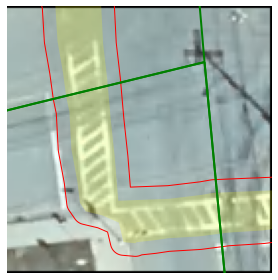

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2
Viewing window intersections 
 15288    MULTILINESTRING ((231846.078 900657.782, 23183...
15296    MULTILINESTRING ((92726.771 861900.062, 92726....
7331     MULTILINESTRING ((131710.094 926966.875, 13172...
94201    MULTILINESTRING ((133292.263 926562.702, 13330...
61079    MULTILINESTRING ((133484.281 926267.625, 13348...
Name: geometry, dtype: geometry
Tp 
 0    MULTILINESTRING ((720507.540 4718428.432, 7205...
1    MULTILINESTRING ((720711.615 4718141.470, 7207...
dtype: geometry


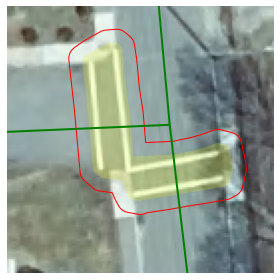

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2
Viewing window intersections 
 15288     MULTILINESTRING ((231846.078 900657.782, 23183...
15296     MULTILINESTRING ((92726.771 861900.062, 92726....
7331      MULTILINESTRING ((131710.094 926966.875, 13172...
166528    MULTILINESTRING ((133353.844 926390.750, 13336...
61079     MULTILINESTRING ((133484.281 926267.625, 13348...
166527    MULTILINESTRING ((133473.906 926401.125, 13349...
Name: geometry, dtype: geometry
Tp 
 0    MULTILINESTRING ((720576.179 4718259.132, 7205...
1    MULTILINESTRING ((720711.615 4718141.470, 7207...
2    MULTILINESTRING ((720695.736 4718274.456, 7207...
dtype: geometry


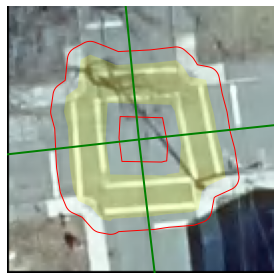

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2
Viewing window intersections 
 15288     MULTILINESTRING ((231846.078 900657.782, 23183...
15296     MULTILINESTRING ((92726.771 861900.062, 92726....
339200    MULTILINESTRING ((133790.312 926674.750, 13380...
3080      MULTILINESTRING ((133543.625 927006.562, 13355...
3271      MULTILINESTRING ((133551.906 926764.250, 13357...
7331      MULTILINESTRING ((131710.094 926966.875, 13172...
11224     MULTILINESTRING ((134448.578 922487.812, 13444...
414761    MULTILINESTRING ((133804.762 926506.113, 13380...
Name: geometry, dtype: geometry
Tp 
 0    MULTILINESTRING ((721022.047 4718393.034, 7210...
dtype: geometry


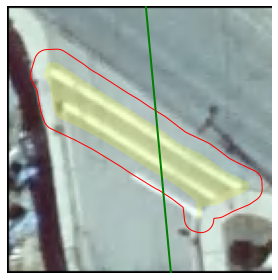

In [255]:
aerial_list = [158, 171, 182, 166]
for i in aerial_list:
    idx = contour_polygon_mappings[contour_polygon_mappings['object_id']==i].index[0]
    superimpose_polygon_on_tile(contour_polygon_mappings, idx)

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200145.jp2


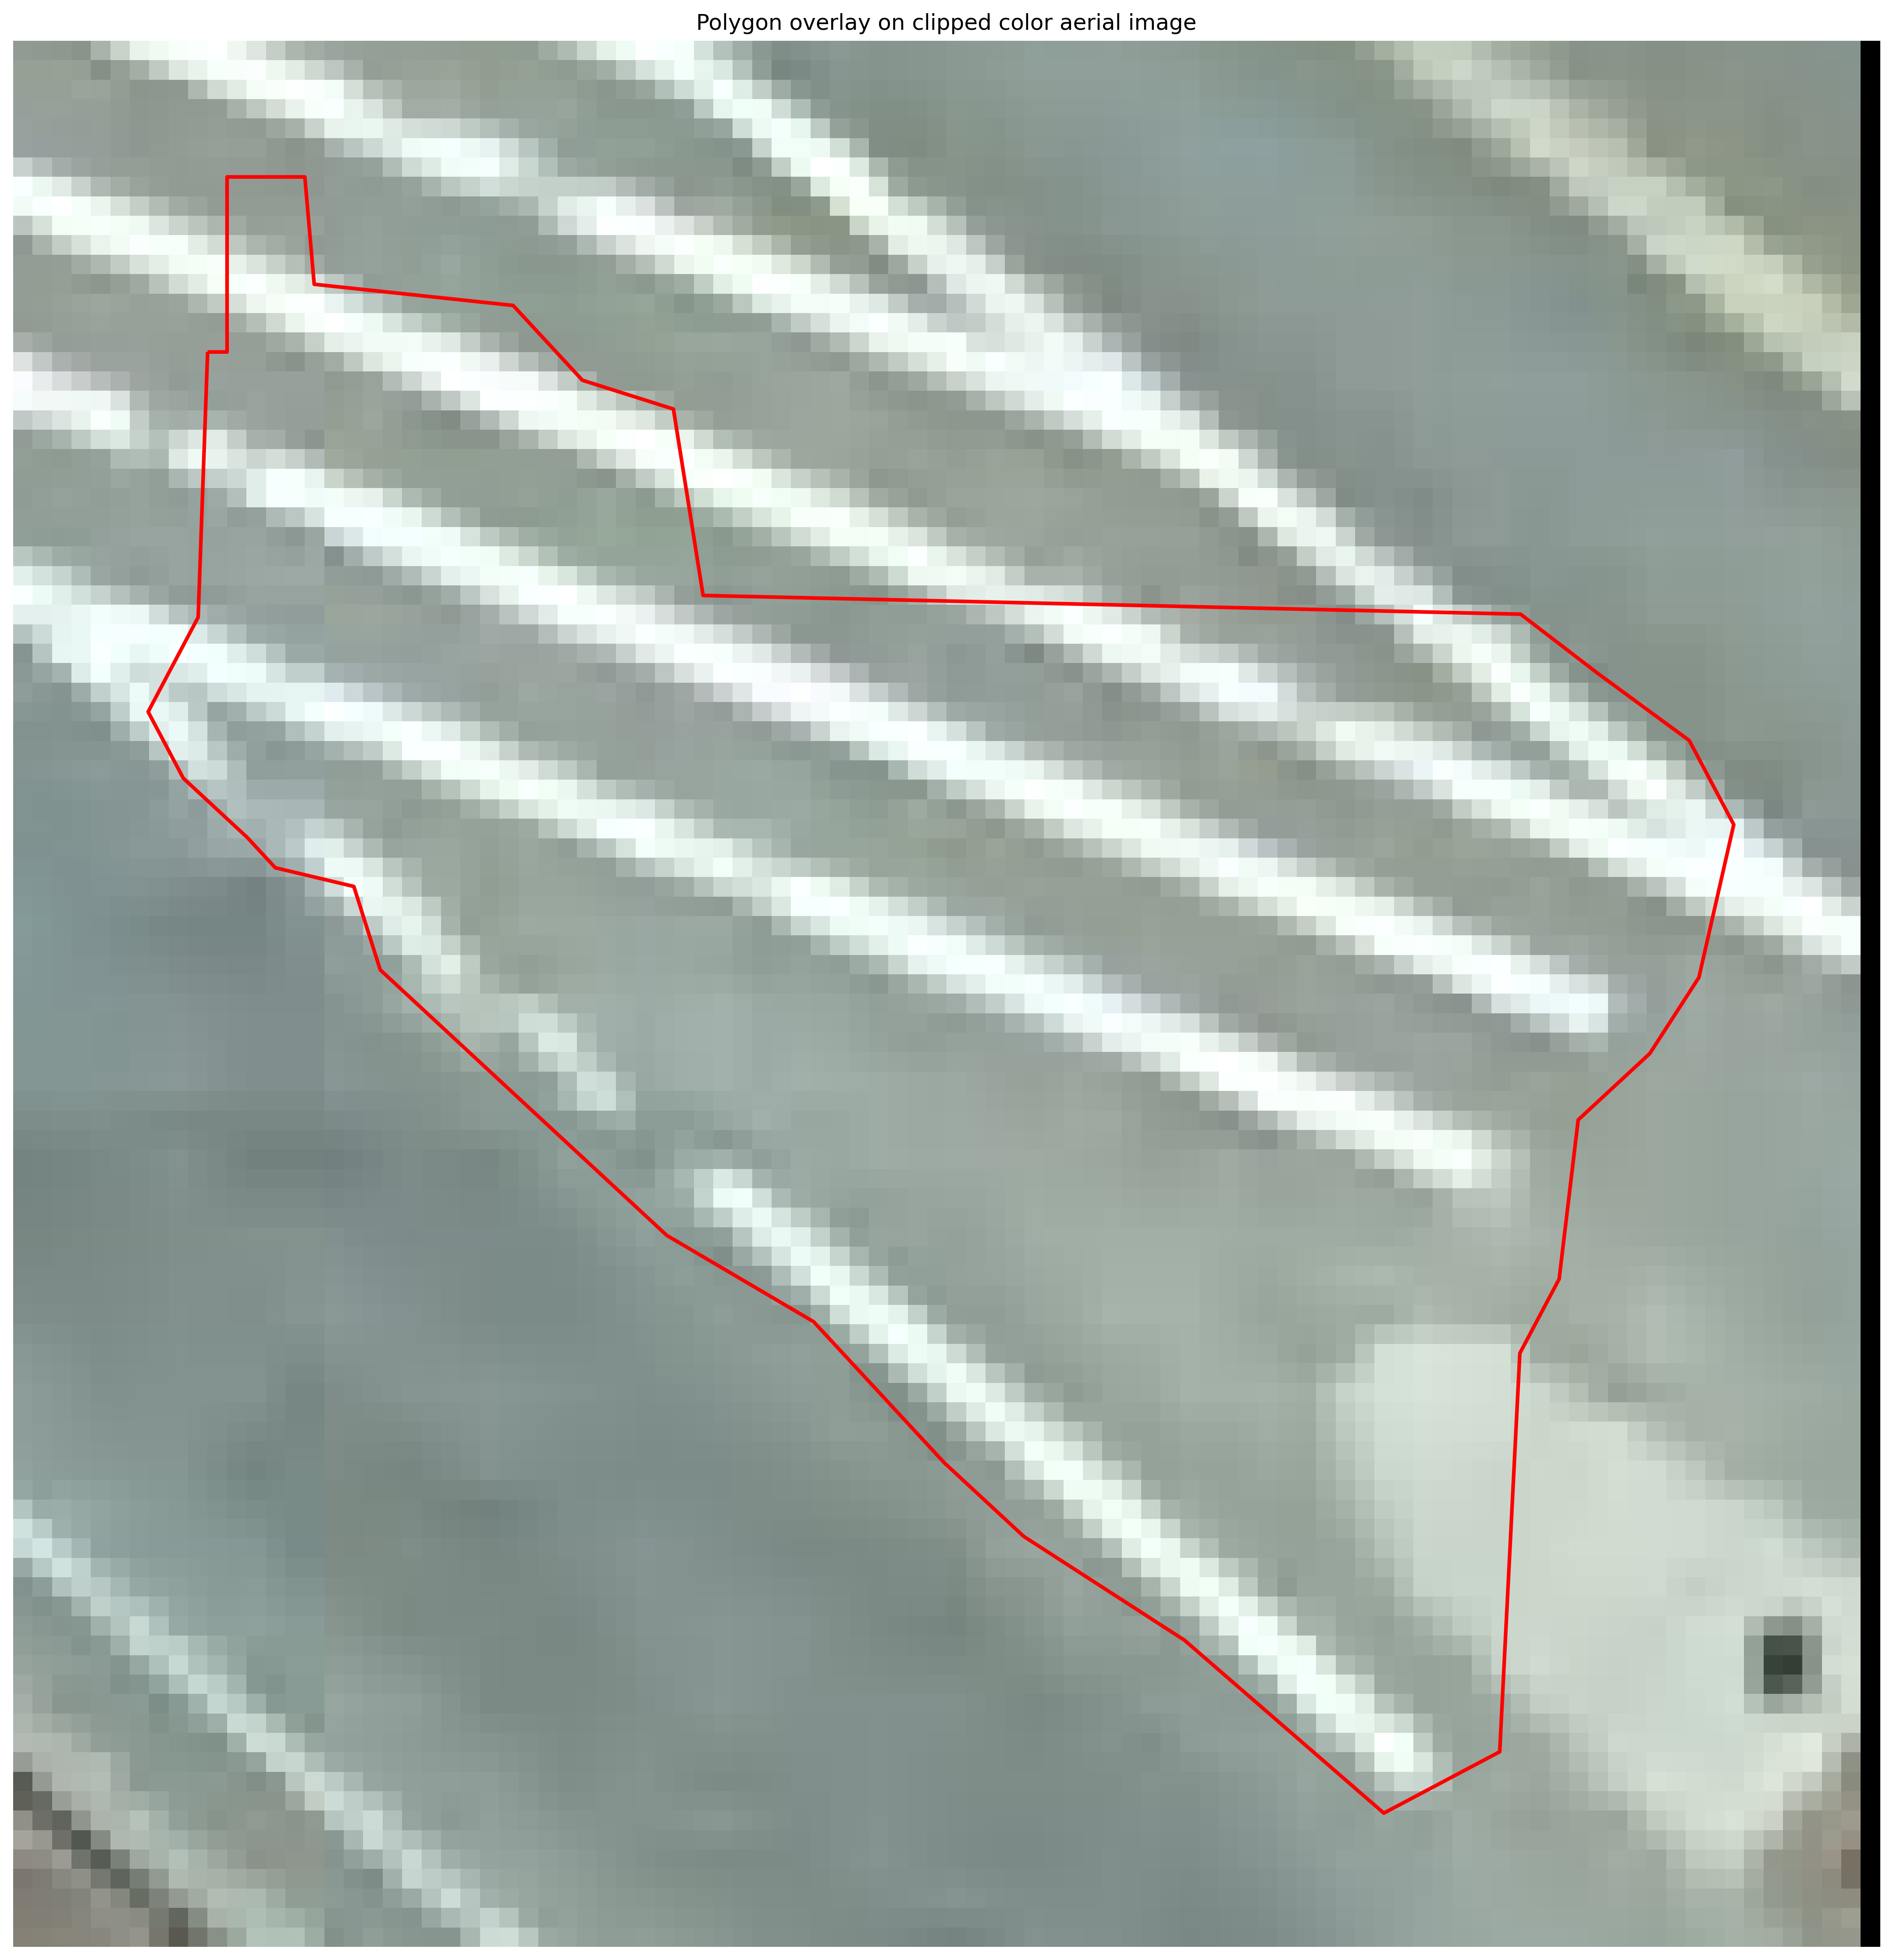

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


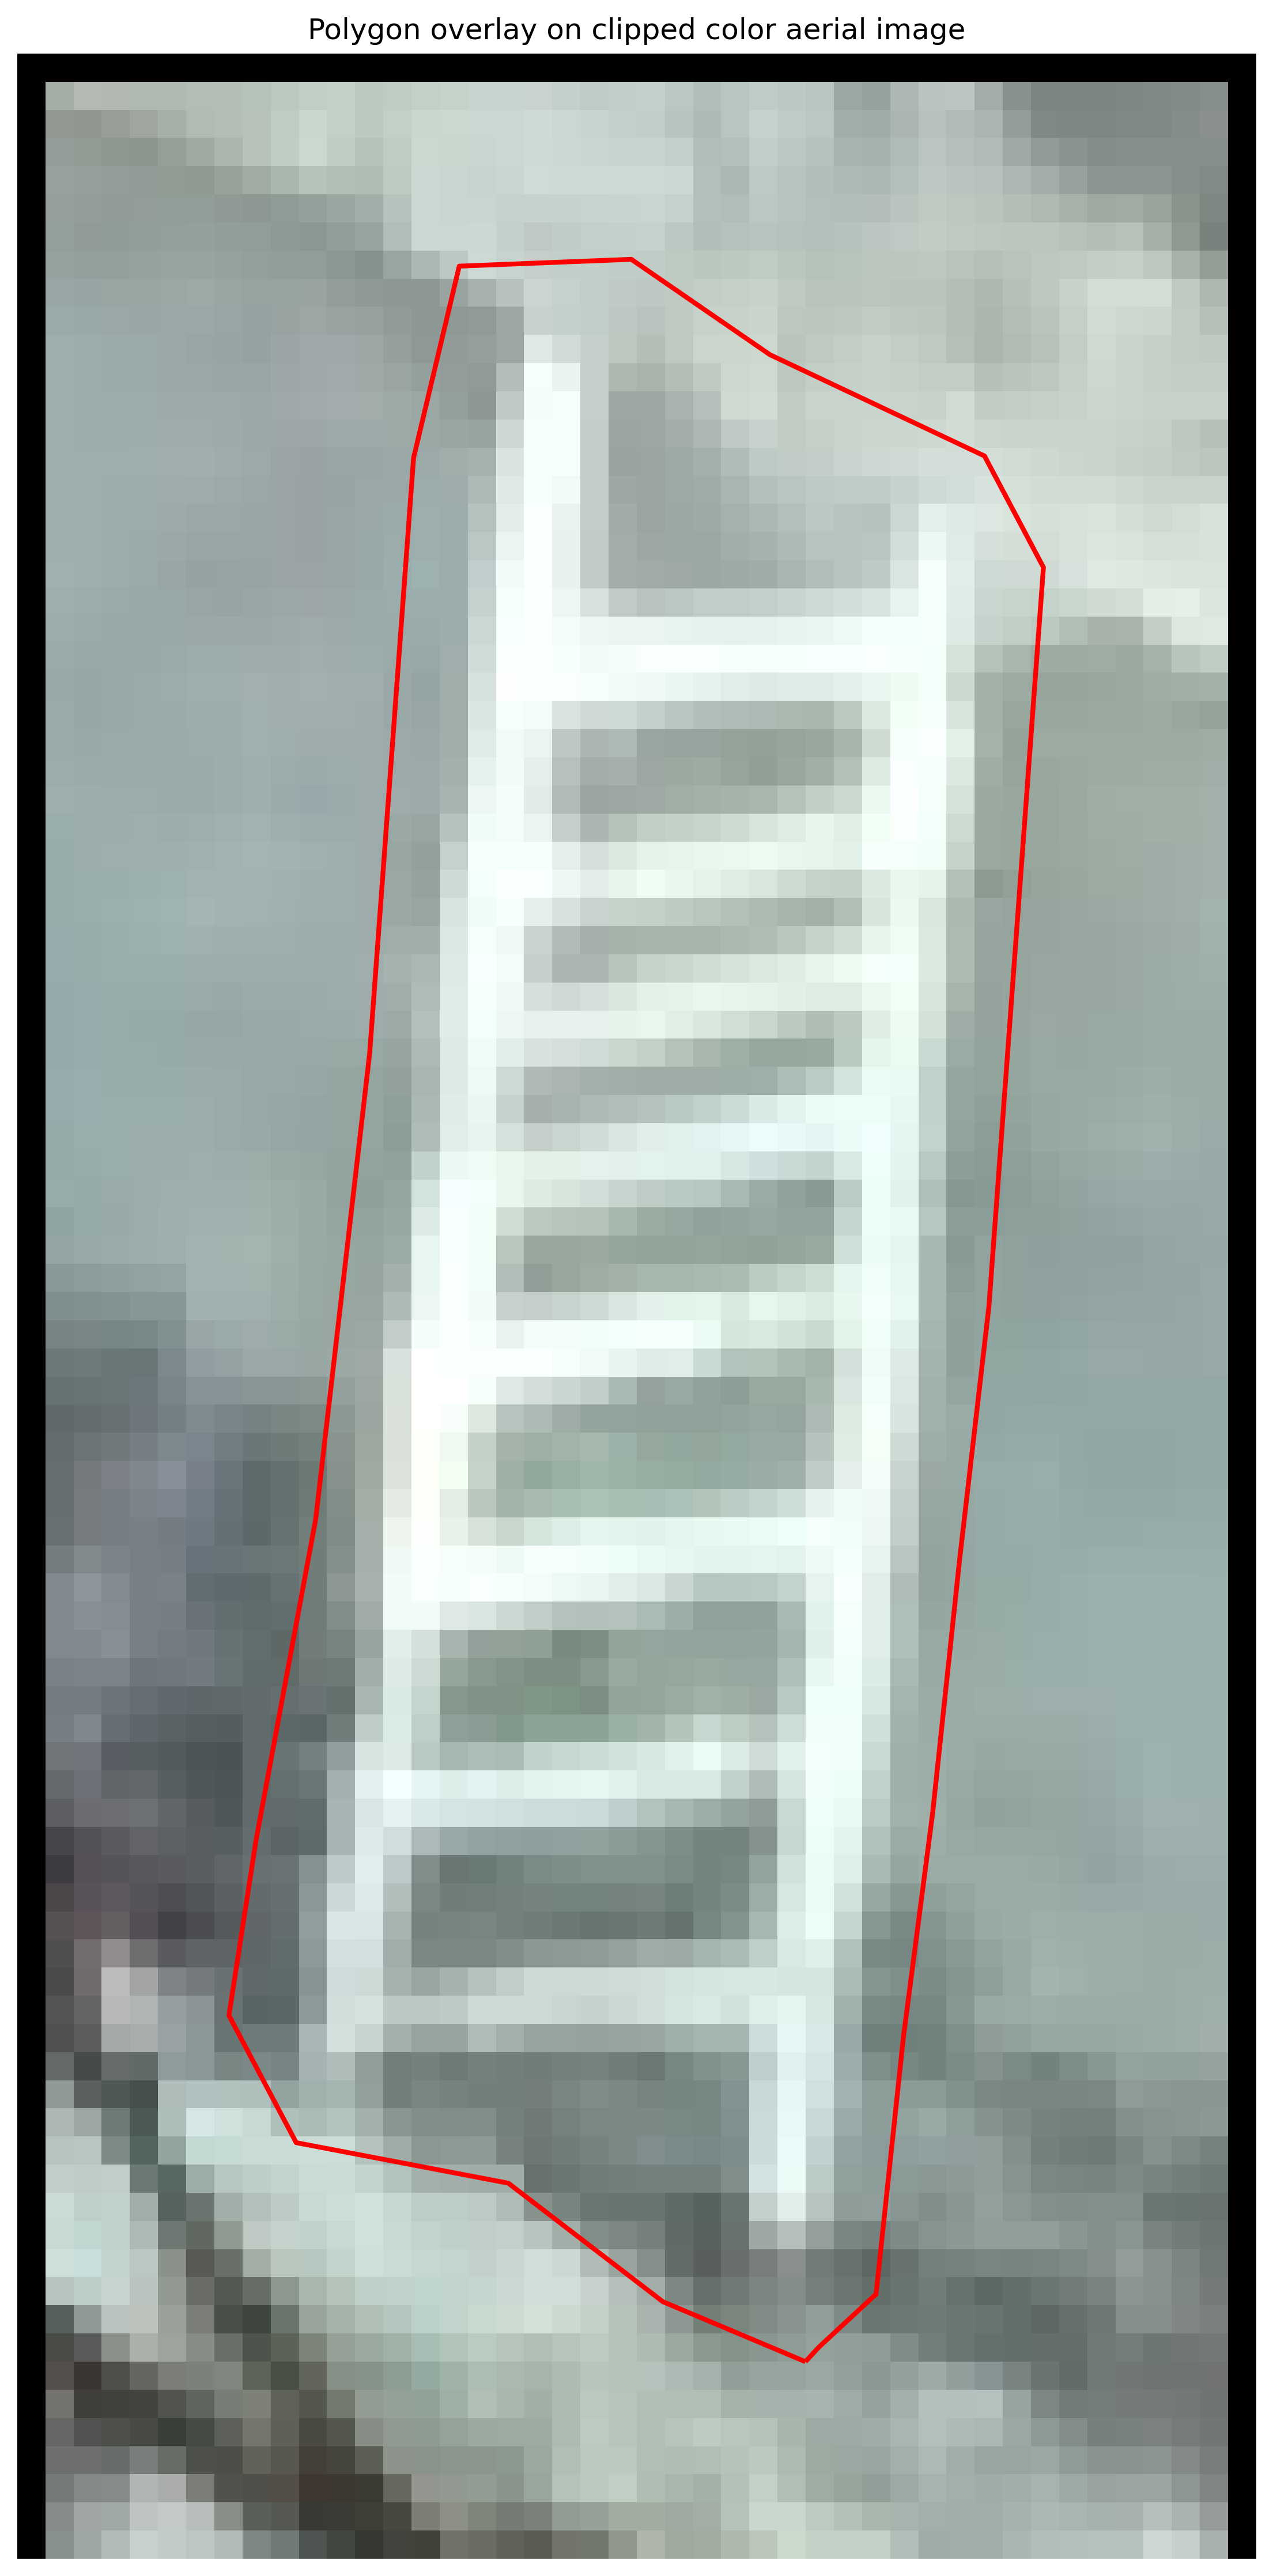

D:/mass_xwalk/COQ2021INDEX/unzipped/18TYN200175.jp2


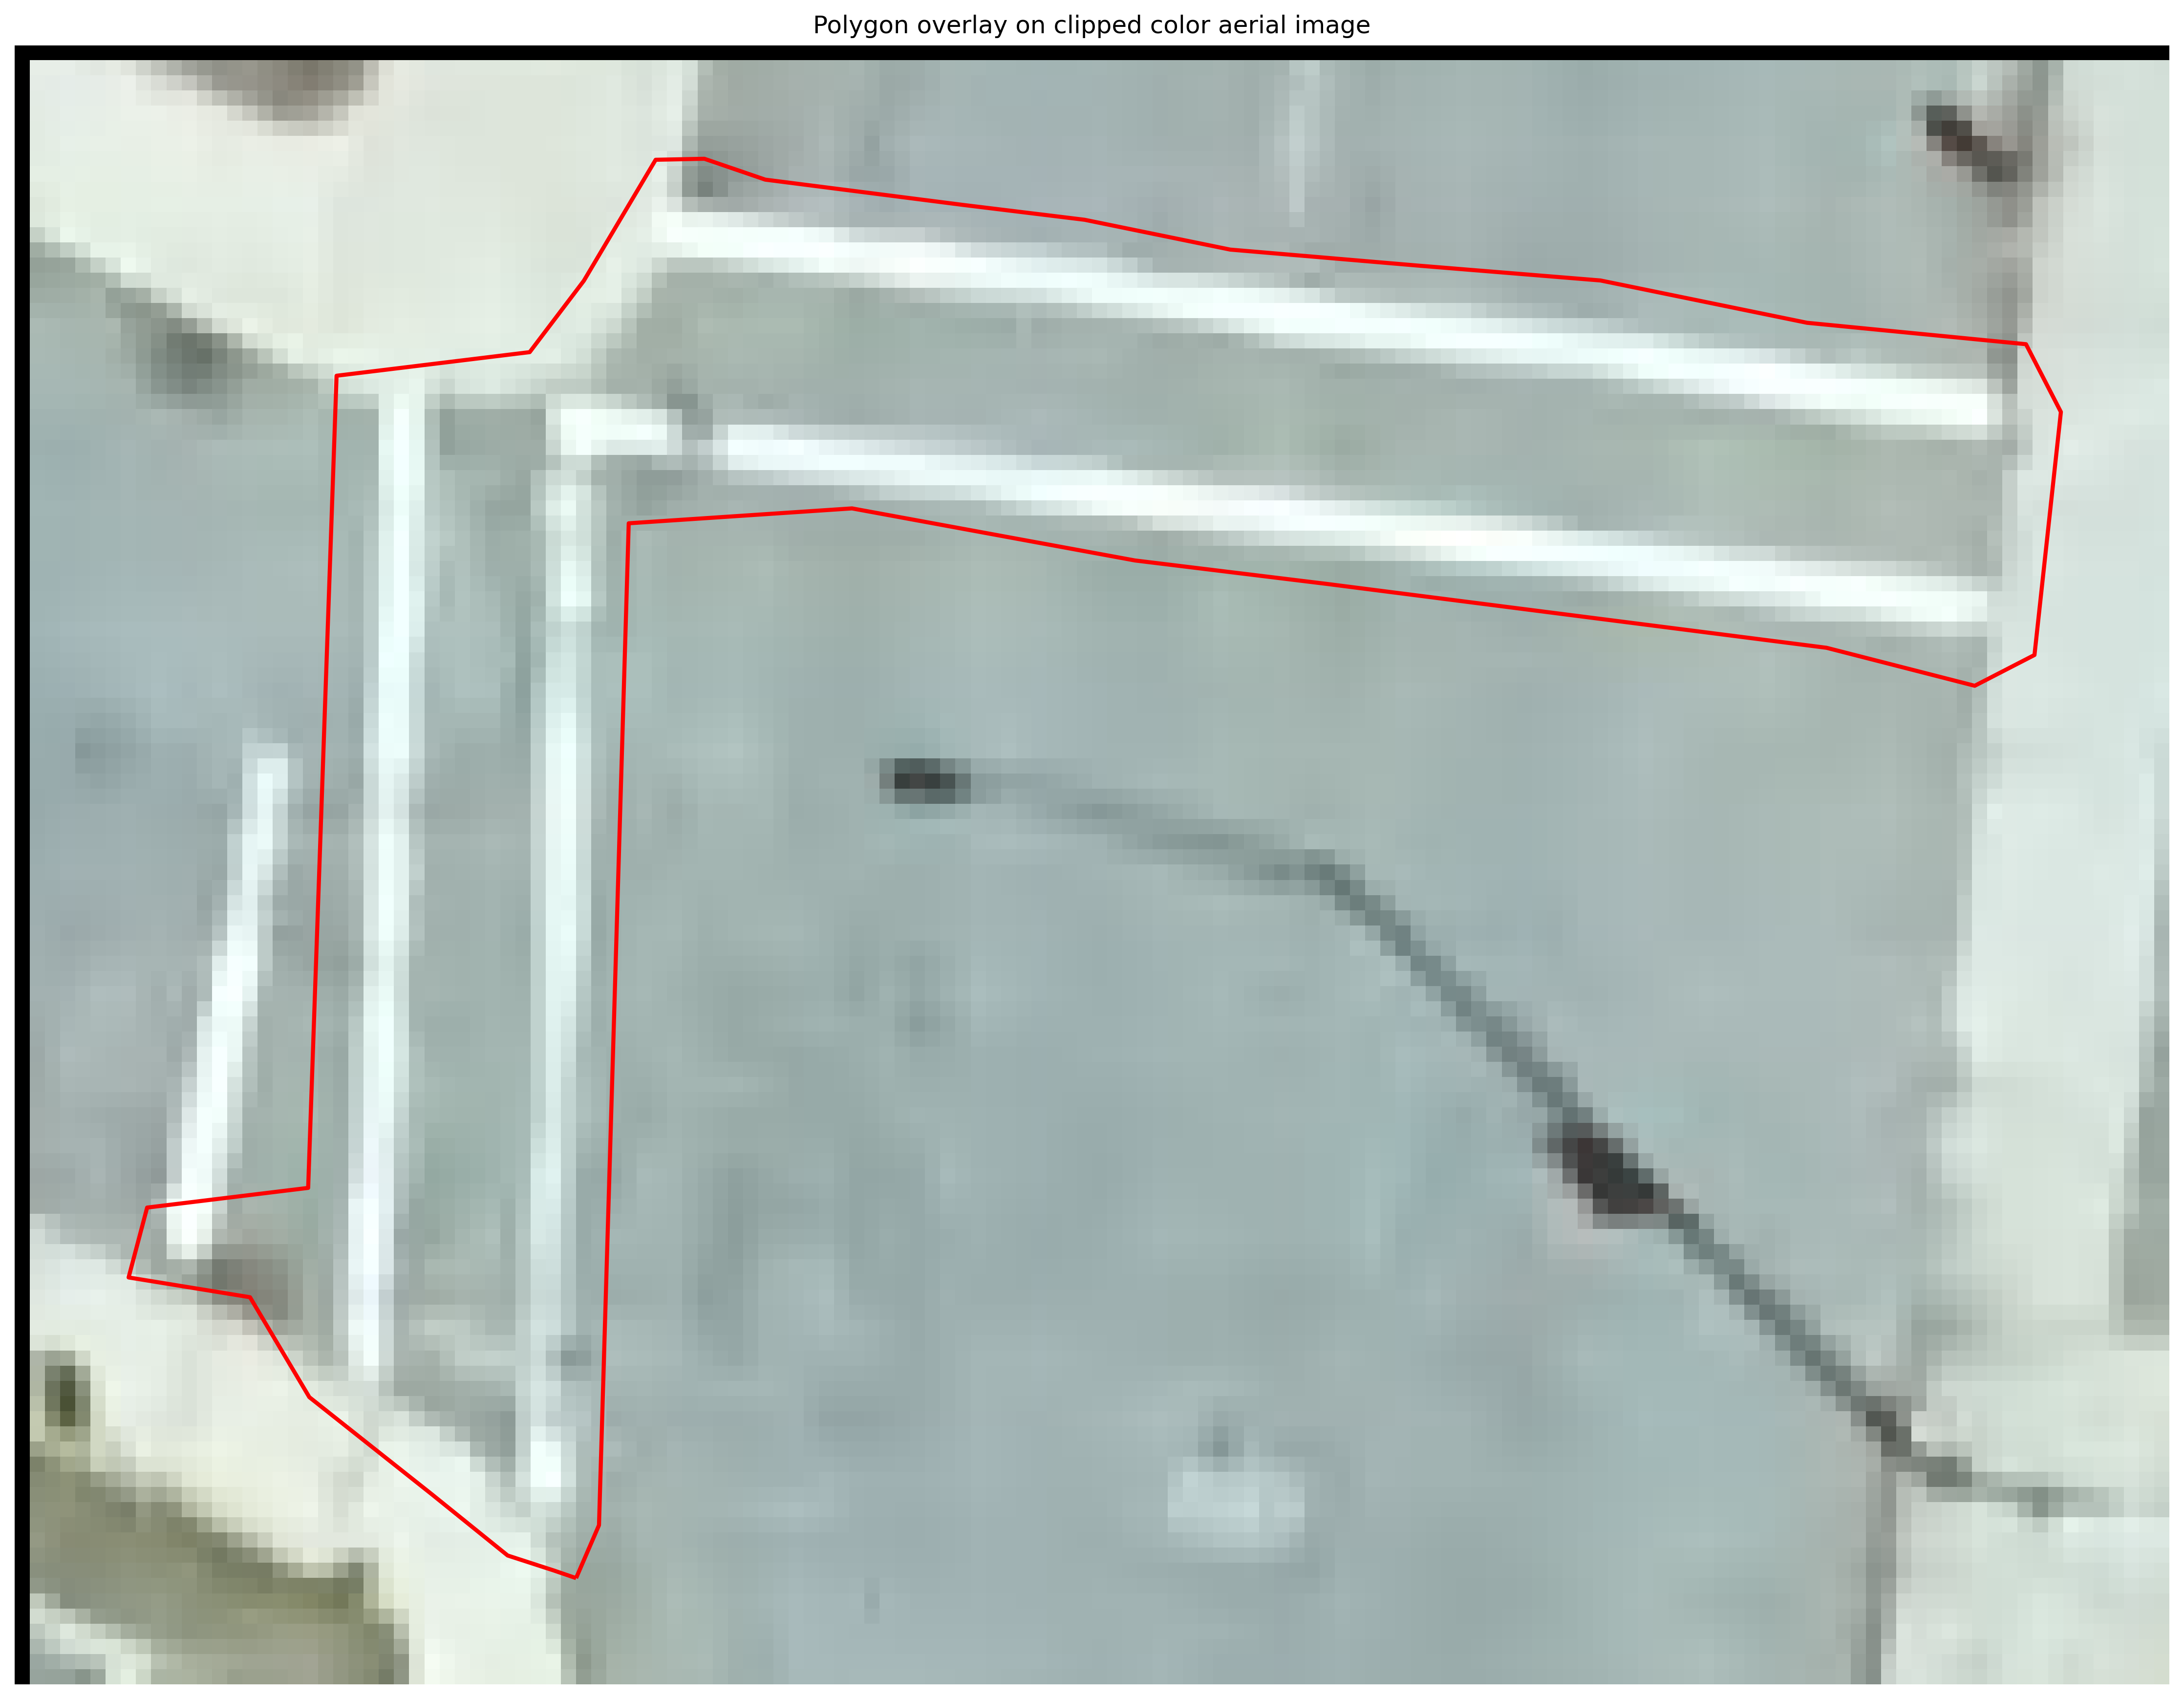

0:00:27.903324


In [72]:
start = time.time()
for i in range(3, 6):
    # visualize_intersection(res_gdf, i)
    superimpose_polygon_on_tile(contour_polygon_mappings, i)
elapsed = time.time() - start
print(timedelta(seconds=elapsed))

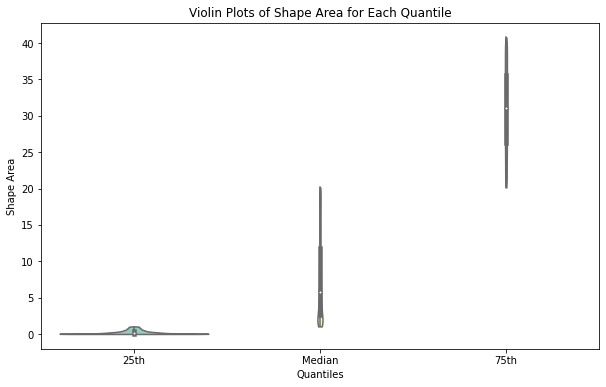

In [18]:
# Create violin plots with Brewer color set
plt.figure(figsize=(10, 6))
sns.violinplot(data=[combined_results['Shape_Area'][quantiles[0.25] > combined_results['Shape_Area']],
                     combined_results['Shape_Area'][(quantiles[0.25] <= combined_results['Shape_Area']) & (combined_results['Shape_Area'] <= quantiles[0.5])],
                     combined_results['Shape_Area'][(quantiles[0.5] < combined_results['Shape_Area']) & (combined_results['Shape_Area'] <= quantiles[0.75])]],
               palette='Set3', cut=0)
plt.xticks([0, 1, 2], ['25th', 'Median', '75th'])
plt.xlabel('Quantiles')
plt.ylabel('Shape Area')
plt.title('Violin Plots of Shape Area for Each Quantile')
plt.savefig("violin_plot_quantiles.jpg", dpi=300)
plt.show()

In [20]:
sample_tile['centroid'] = sample_tile['geometry'].centroid
bounding_box = sample_tile['centroid'].apply(lambda centroid: Point(centroid.x, centroid.y).buffer(1))
roads_transformed['geometry']

In [78]:
def visualize_simple_intersection(polygon_id=33956, road_id=314345, zoom_in=True):
    polygon = western_mass.iloc[polygon_id-1]['geometry']
    road_segment = roads_transformed.iloc[road_id-1]['geometry']
    buffered_polygon = polygon.buffer(1)
    bounding_box = buffered_polygon.bounds
    # Bounding box coordinates
    minx, miny, maxx, maxy = bounding_box
    # Create a Polygon from the bounding box coordinates
    bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
    print(bounding_polygon)
    # Convert objects to geodataframes (gdfs)
    polygon_gdf = gpd.GeoDataFrame(geometry=[polygon])
    bounding_polygon_gdf = gpd.GeoDataFrame(geometry=[bounding_polygon])
    road_segment_gdf = gpd.GeoDataFrame(geometry=[road_segment])
    # Calculate the intersection between the line segment and the bounding box
    intersection = bounding_polygon.intersection(road_segment)
    intersection_gdf = gpd.GeoDataFrame(geometry=[intersection])
    # Visualize the itnersection
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.axis('off')
    polygon_gdf.plot(ax=ax, color='red')
    bounding_polygon_gdf.boundary.plot(ax=ax, linewidth=1, color='green')
    if(zoom_in):
        intersection_gdf.plot(ax=ax)
    else:
        road_segment_gdf.plot(ax=ax)
    plt.savefig("intersection.jpg", dpi=300)
    plt.show()

POLYGON ((699898.9755664704 4664256.05005366, 699912.3360708214 4664256.05005366, 699912.3360708214 4664269.721154339, 699898.9755664704 4664269.721154339, 699898.9755664704 4664256.05005366))


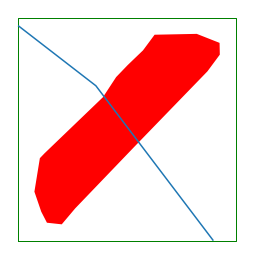

In [79]:
visualize_simple_intersection()

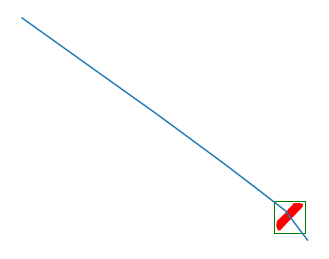

In [75]:
visualize_simple_intersection(zoom_in=False)

<AxesSubplot:>

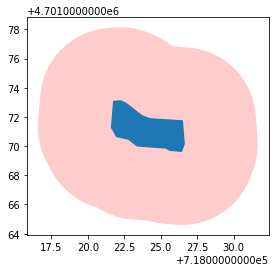

In [125]:
buffered_polygon = combined_results['geometry'][:1].buffer(5)
# bounding_box = buffered_polygon.bounds
# # Bounding box coordinates
# minx, miny, maxx, maxy = bounding_box
# # Create a Polygon from the bounding box coordinates
# bounding_polygon = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
fig, ax = plt.subplots()
buffered_polygon.plot(ax=ax, color='red', alpha=0.2)
combined_results['geometry'][:1].plot(ax=ax)

<AxesSubplot:>

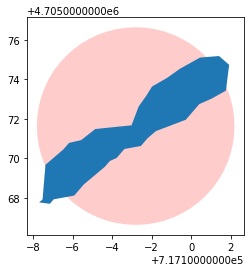

In [117]:

combined_results['centroid'] = combined_results['geometry'].centroid
bounding_box = combined_results['centroid'][2:3].apply(lambda centroid: Point(centroid.x, centroid.y).buffer(5))
fig, ax = plt.subplots()
bounding_box.plot(ax=ax, color='red', alpha=0.2)
combined_results['geometry'][2:3].plot(ax=ax)

In [112]:
combined_results.head()

Id  gridcode                                          MERGE_SRC  \
0   1         2  E:/Crosswalk/Lowell_Amherst_Combined/Down1_Par...   
1   1         2  E:/Crosswalk/Lowell_Amherst_Combined/Down1_Par...   
2   1         2  E:/Crosswalk/Lowell_Amherst_Combined/Down1_Par...   
3   2         2  E:/Crosswalk/Lowell_Amherst_Combined/Down1_Par...   
4   3         2  E:/Crosswalk/Lowell_Amherst_Combined/Down1_Par...   

   MERGE_SRC_1  Shape_Length  Shape_Area  \
0          NaN     14.702197   10.987382   
1          NaN      1.500000    0.135000   
2          NaN     26.518909   20.181546   
3          NaN     16.008430   12.277923   
4          NaN      7.199091    1.165284   

                                            geometry  
0  MULTIPOLYGON (((718026.450 4701069.600, 718025...  
1  MULTIPOLYGON (((717983.250 4703825.550, 717982...  
2  MULTIPOLYGON (((717092.850 4705067.700, 717092...  
3  MULTIPOLYGON (((717086.250 4705063.350, 717085...  
4  MULTIPOLYGON (((717074.700 4705056.150, 717073...

In [72]:
# Normalize values
normalized_shape_area = (gdf_filtered['Shape_Area'] - gdf_filtered['Shape_Area'].mean()) / gdf_filtered['Shape_Area'].std()
# Insert normalized values next to 'Shape_Area'
gdf_filtered.insert(gdf_filtered.columns.get_loc('Shape_Area') + 1, 'Normalized_Shape_Area', normalized_shape_area)

In [74]:
gdf_filtered['Normalized_Shape_Area'].quantile([0.25, 0.5, 0.75])

0.25   -0.554044
0.50   -0.444458
0.75    0.352182
Name: Normalized_Shape_Area, dtype: float64

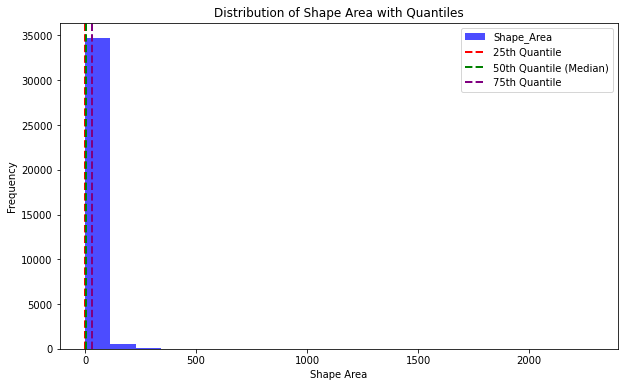

In [75]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(gdf_filtered['Shape_Area'], bins=20, alpha=0.7, color='blue', label='Shape_Area')
plt.axvline(x=quantiles[0.25], color='red', linestyle='dashed', linewidth=2, label='25th Quantile')
plt.axvline(x=quantiles[0.5], color='green', linestyle='dashed', linewidth=2, label='50th Quantile (Median)')
plt.axvline(x=quantiles[0.75], color='purple', linestyle='dashed', linewidth=2, label='75th Quantile')
plt.xlabel('Shape Area')
plt.ylabel('Frequency')
plt.title('Distribution of Shape Area with Quantiles')
plt.legend()
plt.savefig("distribution_shape_area.jpg", dpi=300)
plt.show()

In [49]:
len(normalized_values)

35271

In [51]:
normalized_values

0       -0.227441
1       -0.558385
2        0.052936
3       -0.188085
4       -0.526967
           ...   
35266   -0.348458
35267   -0.559924
35268   -0.562032
35269   -0.559883
35270   -0.559883
Name: Shape_Area, Length: 35271, dtype: float64

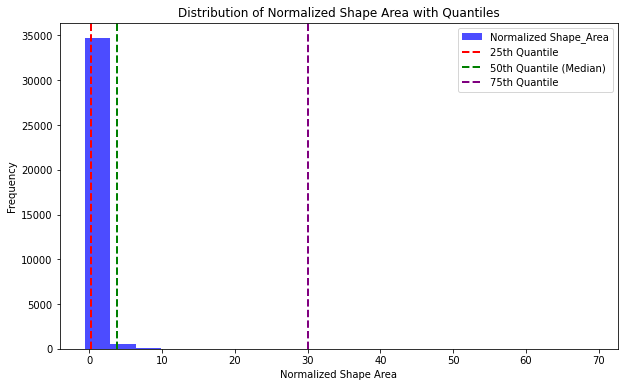

In [62]:
# Create a histogram with normalized values
plt.figure(figsize=(10, 6))
plt.hist(normalized_values, bins=20, alpha=0.7, color='blue', label='Normalized Shape_Area')
plt.axvline(x=quantiles[0.25], color='red', linestyle='dashed', linewidth=2, label='25th Quantile')
plt.axvline(x=quantiles[0.5], color='green', linestyle='dashed', linewidth=2, label='50th Quantile (Median)')
plt.axvline(x=quantiles[0.75], color='purple', linestyle='dashed', linewidth=2, label='75th Quantile')
plt.xlabel('Normalized Shape Area')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Shape Area with Quantiles')
plt.legend()
plt.savefig("distribution_normalized_shape.jpg", dpi=300)
plt.show()

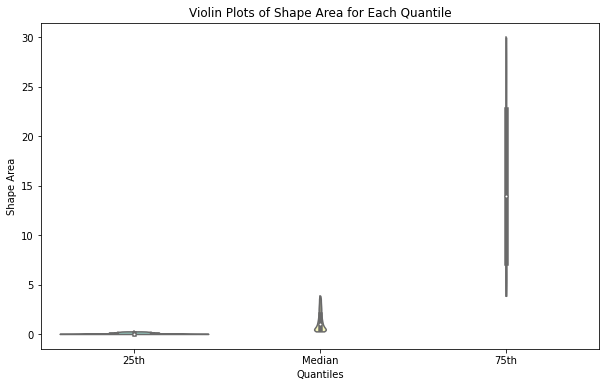

In [81]:
# Create violin plots with Brewer color set
plt.figure(figsize=(10, 6))
sns.violinplot(data=[gdf_filtered['Shape_Area'][quantiles[0.25] > gdf_filtered['Shape_Area']],
                     gdf_filtered['Shape_Area'][(quantiles[0.25] <= gdf_filtered['Shape_Area']) & (gdf_filtered['Shape_Area'] <= quantiles[0.5])],
                     gdf_filtered['Shape_Area'][(quantiles[0.5] < gdf_filtered['Shape_Area']) & (gdf_filtered['Shape_Area'] <= quantiles[0.75])]],
               palette='Set3', cut=0)
plt.xticks([0, 1, 2], ['25th', 'Median', '75th'])
plt.xlabel('Quantiles')
plt.ylabel('Shape Area')
plt.title('Violin Plots of Shape Area for Each Quantile')
plt.savefig("violin_plot_quantiles.jpg", dpi=300)
plt.show()